# Feasibility UQ

Take the generic DEMO solution, turned into an input file. Remove f-values at iteration vars, and replace their equality constraints with inequalities. Run PROCESS once-through with uncertain inputs, and the QoI as the value of constraints, i.e. the feasibility.

In [1]:
import easyvvuq as uq
import chaospy as cp
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Campaign to capture feasibility

Using the epistemic uncertain inputs for the entire code, capture the distribution of constraint residuals.

To start with, make just 2 inputs uncertain (for running locally).

In [5]:
# Define campaign
WORK_DIR = "campaigns"
Path("campaigns").mkdir(exist_ok=True)
campaign = uq.Campaign(name="model_inputs", work_dir=WORK_DIR)

# Define parameter space
# Uncertainties from Alex's SA paper

params = {
    "fgwped": {
        "type": "float",
        "min": 1.1,
        "max": 1.3,
        "default": 1.1,
    },  # check: not sure if this is right var
    "hfact": {"type": "float", "min": 1.0, "max": 1.2, "default": 1.1},
    "coreradius": {"type": "float", "min": 0.45, "max": 0.75, "default": 0.75},
    "fimp_2": {"type": "float", "min": 0.085, "max": 0.115, "default": 0.1},  # check
    "fimp_14": {
        "type": "float",
        "min": 1.0e-5,
        "max": 1.0e-4,
        "default": 5e-5,
    },  # check
    "psepbqarmax": {"type": "float", "min": 8.7, "max": 9.7, "default": 9.2},
    "flhthresh": {"type": "float", "min": 0.85, "max": 1.15, "default": 1.15},  # check
    "bscfmax": {"type": "float", "min": 0.95, "max": 1.05, "default": 0.99},
    "peakfactrad": {"type": "float", "min": 2.0, "max": 3.5, "default": 3.33},
    "kappa": {"type": "float", "min": 1.8, "max": 1.9, "default": 1.8},  # check default
    "etaech": {"type": "float", "min": 0.3, "max": 0.5, "default": 0.4},
    "feffcd": {"type": "float", "min": 0.5, "max": 5.0, "default": 1.0},
    "etath": {"type": "float", "min": 0.36, "max": 0.4, "default": 0.375},
    "etaiso": {"type": "float", "min": 0.75, "max": 0.95, "default": 0.9},
    "boundl_18": {
        "type": "float",
        "min": 3.25,
        "max": 3.75,
        "default": 3.5,
    },  # q^95_min
    "pinjalw": {"type": "float", "min": 51.0, "max": 61.0, "default": 51.0},
    "alstroh": {"type": "float", "min": 6.0e8, "max": 7.2e8, "default": 6.6e8},
    "sig_tf_wp_max": {
        "type": "float",
        "min": 5.2e8,
        "max": 6.4e8,
        "default": 5.8e8,
    },  # winding pack, or casing?
    "aspect": {"type": "float", "min": 3.0, "max": 3.2, "default": 3.1},
    "boundu_2": {
        "type": "float",
        "min": 11.0,
        "max": 12.0,
        "default": 11.5,
    },  # B_T^max: check default
    "triang": {"type": "float", "min": 0.4, "max": 0.6, "default": 0.5},
    "out_file": {"type": "string", "default": "out.csv"},
}

# QoIs
# Violated constraint residuals
qois = [
    "vio_constr_res",
]

# Create encoder and decoder
encoder = uq.encoders.GenericEncoder(
    template_fname="demo_sol_no_f_IN.template", target_filename="IN.DAT"
)
decoder = uq.decoders.JSONDecoder(
    target_filename="constraints.json", output_columns=qois
)

cmd = "process -i IN.DAT"
actions = uq.actions.local_execute(encoder, cmd, decoder)

# Add the app
campaign.add_app(name="feasibility", params=params, actions=actions)

# Create PCE sampler
vary = {
    "aspect": cp.Uniform(3.0, 3.2),
    "triang": cp.Uniform(0.4, 0.6),
    "psepbqarmax": cp.Uniform(8.7, 9.7),
    "hfact": cp.Uniform(1.0, 1.2),
}
pce_sampler = uq.sampling.PCESampler(vary=vary, polynomial_order=3)

# Add pce_sampler to campaign
campaign.set_sampler(pce_sampler)

# Draw samples, execute and collate
campaign.execute().collate(progress_bar=True)
samples = campaign.get_collation_result()

  0%|          | 0/256 [00:00<?, ?it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:12 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
  0%|          | 1/256 [00:02<12:38,  2.97s/it]

 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:12 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsotc6x0z5/runs/runs_0-100000000/runs_0-1000000/runs_0-1000

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
  1%|          | 2/256 [00:03<06:46,  1.60s/it]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
constrs = array([-9.00130490e-02,  6.91775134e-02,  9.21225563e-03,  3.25128420e-02,
        1.21187199e+00,  2.37234408e-01,  2.27832545e-01,  8.50553163e-02,
       -1.96078431e-02, -8.71703367e-02,  4.70408708e-01,  3.78529705e-01,
        1.61719522e+01,  1.27856702e+01,  4.48778598e+00, -4.43186513e-03,
       -1.78656936e-05,  3.05237375e+00,  2.34292933e+00,  3.01999113e-01,
        2.18271761e-01,  1.89079226e-03,  2.87571867e-01, -4.62884093e-01,
        2.74732283e-01, -1.62493237e-03,  2.09458920e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3794E+00
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 ***********************************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
The IN.DAT file does not contain any obsolete variables.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 **************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
  1%|          | 3/256 [00:03<04:19,  1.02s/it]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
constrs = array([-9.00130490e-02,  3.30506360e-02,  9.21225563e-03,  3.25128420e-02,
        1.21187199e+00,  2.37234408e-01,  2.27832545e-01,  8.50553163e-02,
       -1.96078431e-02, -8.71703367e-02,  4.70408708e-01,  3.78529705e-01,
        1.61719522e+01,  1.27856702e+01,  4.48778598e+00, -4.43186513e-03,
       -1.786569

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
  2%|▏         | 6/256 [00:04<01:43,  2.41it/s]

constrs = array([-9.00130490e-02,  1.21623989e-01,  9.21225563e-03,  3.25128420e-02,
        1.21187199e+00,  2.37234408e-01,  2.27832545e-01,  8.50553163e-02,
       -1.96078431e-02, -8.71703367e-02,  4.70408708e-01,  3.78529705e-01,
        1.61719522e+01,  1.27856702e+01,  4.48778598e+00, -4.43186513e-03,
       -1.78656936e-05,  3.05237375e+00,  2.34292933e+00,  3.85048687e-01,
        2.18271761e-01,  1.89079226e-03,  2.87571867e-01, -4.62884093e-01,
        2.37947524e-01, -1.62493237e-03,  2.09458920e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3794E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit o

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 


  3%|▎         | 7/256 [00:05<01:59,  2.09it/s]

constrs = array([-9.00130490e-02,  1.21623989e-01,  9.21225563e-03,  3.25128420e-02,
        1.21187199e+00,  2.37234408e-01,  2.27832545e-01,  8.50553163e-02,
       -1.96078431e-02, -8.71703367e-02,  4.70408708e-01,  3.78529705e-01,
        1.61719522e+01,  1.27856702e+01,  4.48778598e+00, -4.43186513e-03,
       -1.78656936e-05,  3.05237375e+00,  2.34292933e+00,  3.85048687e-01,
        2.18271761e-01,  1.89079226e-03,  2.87571867e-01, -4.62884093e-01,
        2.74732283e-01, -1.62493237e-03,  2.09458920e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3794E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit o

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
  4%|▎         | 9/256 [00:05<01:21,  3.05it/s]

constrs = array([-9.00130490e-02,  1.66583522e-01,  9.21225563e-03,  3.25128420e-02,
        1.21187199e+00,  2.37234408e-01,  2.27832545e-01,  8.50553163e-02,
       -1.96078431e-02, -8.71703367e-02,  4.70408708e-01,  3.78529705e-01,
        1.61719522e+01,  1.27856702e+01,  4.48778598e+00, -4.43186513e-03,
       -1.78656936e-05,  3.05237375e+00,  2.34292933e+00,  4.56242604e-01,
        2.18271761e-01,  1.89079226e-03,  2.87571867e-01, -4.62884093e-01,
        2.74732283e-01, -1.62493237e-03,  2.09458920e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3794E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit o

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
  5%|▍         | 12/256 [00:06<01:06,  3.68it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:16 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
  5%|▌         | 13/256 [00:06<01:24,  2.87it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:16 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:17 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
  5%|▌         | 14/256 [00:08<02:45,  1.46it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calcula

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
  6%|▋         | 16/256 [00:09<02:10,  1.84it/s]

constrs = array([-9.97127217e-02,  1.06450103e-01,  9.21225563e-03,  6.07018806e-02,
        1.26453924e+00,  2.63950256e-01,  1.75697799e-01,  4.96647789e-02,
       -1.96078431e-02, -1.18727760e-01,  4.95957683e-01,  3.78529705e-01,
        1.61670485e+01,  1.27379930e+01,  4.48778598e+00, -6.94483610e-03,
       -1.78656936e-05,  3.05237375e+00,  2.33728588e+00,  3.78445603e-01,
        2.18271761e-01,  3.45135232e-04,  2.85585478e-01, -4.84441964e-01,
        2.89959796e-01, -1.62493237e-03,  2.09458920e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.0083E+07  normalised_total_beta =    3.3138E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current i

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
  7%|▋         | 17/256 [00:09<01:54,  2.08it/s]

The IN.DAT file does not contain any obsolete variables.
constrs = array([-9.97127217e-02,  5.48397272e-02,  9.21225563e-03,  6.07018806e-02,
        1.26453924e+00,  2.63950256e-01,  1.75697799e-01,  4.96647789e-02,
       -1.96078431e-02, -1.18727760e-01,  4.95957683e-01,  3.78529705e-01,
        1.61670485e+01,  1.27379930e+01,  4.48778598e+00, -6.94483610e-03,
       -1.78656936e-05,  3.05237375e+00,  2.33728588e+00,  2.95791960e-01,
        2.18271761e-01,  3.45135232e-04,  2.85585478e-01, -4.84441964e-01,
        3.28290064e-01, -1.62493237e-03,  2.09458920e-02])
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.0083E+07  normalised_total_beta =    3.3138E+00
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **********

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
  7%|▋         | 18/256 [00:09<01:41,  2.34it/s]

The IN.DAT file does not contain any obsolete variables.
constrs = array([-9.97127217e-02,  1.92887835e-02,  9.21225563e-03,  6.07018806e-02,
        1.26453924e+00,  2.63950256e-01,  1.75697799e-01,  4.96647789e-02,
       -1.96078431e-02, -1.18727760e-01,  4.95957683e-01,  3.78529705e-01,
        1.61670485e+01,  1.27379930e+01,  4.48778598e+00, -6.94483610e-03,
       -1.78656936e-05,  3.05237375e+00,  2.33728588e+00,  2.38857380e-01,
        2.18271761e-01,  3.45135232e-04,  2.85585478e-01, -4.84441964e-01,
        3.28290064e-01, -1.62493237e-03,  2.09458920e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.0083E+07  normalised_total_beta =    3.3138E+00
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 
 ******************************************** Errors and Warnings ******************************************

  7%|▋         | 19/256 [00:10<01:35,  2.49it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:20 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

  8%|▊         | 21/256 [00:10<01:22,  2.85it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-9.97127217e-02,  1.06450103e-01,  9.21225563e-03,  6.07018806e-02,
        1.26453924e+00,  2.63950256e-01,  1.75697799e-01,  4.96647789e-02,
       -1.96078431e-02, -1.18727760e-01,  4.95957683e-01,  3.78529705e-01,
        1.61670485e+01,  1.27379930e+01,  4.48778598e+00, -6.94483610e-03,
       -1.78656936e-05,  3.05237375e+00,  2.33728588e+00,  3.78445603e-01,
        2.18271761e-01,  3.45135232e-04,  2.85585478e-01, -4.84441964e-01,
        3.28290064e-01, -1.62493237e-03,  2.09458920e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.0083E+07  normalised_total_beta =    3.3138E+00
constrs = array([-9.97127217e-02,  1.50692892e-01,  9.21225563e-03,  6.07018806e-02,
        1.26453924e+00,  2.63950256e-01,  1.75697799e-01,  4.96647789e-02,
       -1.96078431e-02, -1.18727760e-01,  4.95957683e-01,  3.78529705e-01,
        1.61670485e+01,  1.27379

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
  9%|▊         | 22/256 [00:11<01:33,  2.50it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
constrs = array([-9.97127217e-02,  1.92887835e-02,  9.21225563e-03,  6.07018806e-02,
        1.26453924e+00,  2.63950256e-01,  1.75697799e-01,  4.96647789e-02,
       -1.96078431e-02, -1.18727760e-01,  4.95957683e-01,  3.78529705e-01,
        1.61670485e+01,  1.27379930e+01,  4.48778598e+00, -6.94483610e-03,
       -1.78656936e-05,  3.05237375e+00,  2.33728588e+00,  2.38857380e-01

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
  9%|▉         | 24/256 [00:12<01:39,  2.34it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:22 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 10%|▉         | 25/256 [00:12<01:54,  2.02it/s]

constrs = array([-9.97127217e-02,  5.48397272e-02,  9.21225563e-03,  6.07018806e-02,
        1.26453924e+00,  2.63950256e-01,  1.75697799e-01,  4.96647789e-02,
       -1.96078431e-02, -1.18727760e-01,  4.95957683e-01,  3.78529705e-01,
        1.61670485e+01,  1.27379930e+01,  4.48778598e+00, -6.94483610e-03,
       -1.78656936e-05,  3.05237375e+00,  2.33728588e+00,  2.95791960e-01,
        2.18271761e-01,  3.45135232e-04,  2.85585478e-01, -4.84441964e-01,
        3.78300359e-01, -1.62493237e-03,  2.09458920e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.0083E+07  normalised_total_beta =    3.3138E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current i

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-9.97127217e-02,  1.06450103e-01,  9.21225563e-03,  6.07018806e-02,
        1.26453924e+00,  2.63950256e-01,  1.75697799e-01,  4.96647789e-02,
       -1.96078431e-02, -1.18727760e-01,  4.95957683e-01,  3.78529705e-01,
        1.61670485e+01,  1.27379930e+01,  4.48778598e+00, -6.94483610e-03,
       -1.78656936e-05,  3.05237375e+00,  2.33728588e+00,  3.78445603e-01,
        2.18271761e-01,  3.45135232e-04,  2.85585478e-01, -4.84441964e-01,
        4.16630627e-01, -1.62493237e-03,  2.09458920e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.0083E+07  normalised_total_beta =    3.3138E+00
constrs = array([-9.97127217e-02,  1.50692892e-01,  9.21225563e-03,  6.07018806e-02,
        1.26453924e+00,  2.63950256e-01,  1.75697799e-01,  4.96647789e-02,
       -1.96078431e-02, -1.18727760e-01,  4.95957683e-01,  3.78529705e-01,
        1.61670485e+01,  1.27379

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


The IN.DAT file does not contain any obsolete variables.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:23 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputs

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.



 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.0083E+07  normalised_total_beta =    3.3138E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 11%|█         | 28/256 [00:14<01:27,  2.60it/s]

constrs = array([-9.97127217e-02,  5.48397272e-02,  9.21225563e-03,  6.07018806e-02,
        1.26453924e+00,  2.63950256e-01,  1.75697799e-01,  4.96647789e-02,
       -1.96078431e-02, -1.18727760e-01,  4.95957683e-01,  3.78529705e-01,
        1.61670485e+01,  1.27379930e+01,  4.48778598e+00, -6.94483610e-03,
       -1.78656936e-05,  3.05237375e+00,  2.33728588e+00,  2.95791960e-01,
        2.18271761e-01,  3.45135232e-04,  2.85585478e-01, -4.84441964e-01,
        4.16630627e-01, -1.62493237e-03,  2.09458920e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.0083E+07  normalised_total_beta =    3.3138E+00
constrs = array([-1.12552309e-01,  1.29457345e-01,  9.21225563e-03,  1.01156812e-01,
        1.33768836e+00,  3.00129310e-01,  1.07857025e-01, -1.70485834e-02,
       -1.96078431e-02, -1.59637061e-01,  5.32112867e-01,  3.78529705e-01,
        1.61666608e+01,  1.26824

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 **************

 12%|█▏        | 31/256 [00:15<01:23,  2.71it/s]

 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:25 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebo

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 13%|█▎        | 34/256 [00:16<01:08,  3.23it/s]

constrs = array([-1.12552309e-01,  3.56880164e-02,  9.21225563e-03,  1.01156812e-01,
        1.33768836e+00,  3.00129310e-01,  1.07857025e-01, -1.70485834e-02,
       -1.96078431e-02, -1.59637061e-01,  5.32112867e-01,  3.78529705e-01,
        1.61666608e+01,  1.26824565e+01,  4.48778598e+00, -9.87937482e-03,
       -1.78656936e-05,  3.05237375e+00,  2.33069031e+00,  2.86969026e-01,
        2.18271761e-01, -1.45450219e-03,  2.83272689e-01, -5.13451672e-01,
        3.86191970e-01, -1.62493237e-03,  2.09458920e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.0633E+07  normalised_total_beta =    3.2255E+00
The IN.DAT file does not contain any obsolete variables.
 
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 ******************************************** Errors and Warnings ******************************************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-9.97127217e-02,  1.92887835e-02,  9.21225563e-03,  6.07018806e-02,
        1.26453924e+00,  2.63950256e-01,  1.75697799e-01,  4.96647789e-02,
       -1.96078431e-02, -1.18727760e-01,  4.95957683e-01,  3.78529705e-01,
        1.61670485e+01,  1.27379930e+01,  4.48778598e+00, -6.94483610e-03,
       -1.78656936e-05,  3.05237375e+00,  2.33728588e+00,  2.38857380e-01,
        2.18271761e-01,  3.45135232e-04,  2.85585478e-01, -4.84441964e-01,
        4.16630627e-01, -1.62493237e-03,  2.09458920e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.0083E+07  normalised_total_beta =    3.3138E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current i

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-1.12552309e-01,  8.61763886e-02,  9.21225563e-03,  1.01156812e-01,
        1.33768836e+00,  3.00129310e-01,  1.07857025e-01, -1.70485834e-02,
       -1.96078431e-02, -1.59637061e-01,  5.32112867e-01,  3.78529705e-01,
        1.61666608e+01,  1.26824565e+01,  4.48778598e+00, -9.87937482e-03,
       -1.78656936e-05,  3.05237375e+00,  2.33069031e+00,  3.69059888e-01,
        2.18271761e-01, -1.45450219e-03,  2.83272689e-01, -5.13451672e-01,
        4.27381711e-01, -1.62493237e-03,  2.09458920e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.0633E+07  normalised_total_beta =    3.2255E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current i

 14%|█▎        | 35/256 [00:16<01:43,  2.13it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:26 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 14%|█▍        | 37/256 [00:17<01:12,  3.03it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:27 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 15%|█▍        | 38/256 [00:18<01:40,  2.17it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:27 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 15%|█▌        | 39/256 [00:18<01:50,  1.96it/s]

 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 16%|█▌        | 40/256 [00:19<01:32,  2.33it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
The IN.DAT file does not contain any obsolete variables.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:29 +01:00(hh:mm) UTC
      User

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:29 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 16%|█▌        | 41/256 [00:19<02:05,  1.72it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 16%|█▋        | 42/256 [00:20<01:39,  2.15it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
constrs = array([-1.12552309e-01,  8.61763886e-02,  9.21225563e-03,  1.01156812e-01,
        1.33768836e+00,  3.00129310e-01,  1.07857025e-01, -1.70485834e-02,
       -1.96078431e-02, -1.59637061e-01,  5.32112867e-01,  3.78529705e-01,
        1.61666608e+01,  1.26824565e+01,  4.48778598e+00, -9.87937482e-03,
       -1.78656936e-05,  3.05237375e+00,  2.33069031e+00,  3.69059888e-01

 17%|█▋        | 43/256 [00:20<01:32,  2.29it/s]

constrs = array([-1.12552309e-01,  3.56880164e-02,  9.21225563e-03,  1.01156812e-01,
        1.33768836e+00,  3.00129310e-01,  1.07857025e-01, -1.70485834e-02,
       -1.96078431e-02, -1.59637061e-01,  5.32112867e-01,  3.78529705e-01,
        1.61666608e+01,  1.26824565e+01,  4.48778598e+00, -9.87937482e-03,
       -1.78656936e-05,  3.05237375e+00,  2.33069031e+00,  2.86969026e-01,
        2.18271761e-01, -1.45450219e-03,  2.83272689e-01, -5.13451672e-01,
        4.81122820e-01, -1.62493237e-03,  2.09458920e-02])
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 *********************************************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 17%|█▋        | 44/256 [00:20<01:25,  2.47it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:30 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 18%|█▊        | 45/256 [00:21<01:25,  2.47it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:31 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density                            
  
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
constrs = array([-1.12552309e-01,  3.56880164e-02,  9.21225563e-03,  1.01156812e-01,
        1.33768836e+00,  3.00129310e-01,  1.07857025e-01, -1.70485834e-02,
       -1.96078431e-02, -1.59637061e-01,  5.32112867e-01,  3.78529705e-01,
        1.61666608e+01,  1.26824565e+01,  4.48778598

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 18%|█▊        | 46/256 [00:21<01:45,  1.99it/s]

constrs = array([-1.12552309e-01,  9.09945942e-04,  9.21225563e-03,  1.01156812e-01,
        1.33768836e+00,  3.00129310e-01,  1.07857025e-01, -1.70485834e-02,
       -1.96078431e-02, -1.59637061e-01,  5.32112867e-01,  3.78529705e-01,
        1.61666608e+01,  1.26824565e+01,  4.48778598e+00, -9.87937482e-03,
       -1.78656936e-05,  3.05237375e+00,  2.33069031e+00,  2.30422109e-01,
        2.18271761e-01, -1.45450219e-03,  2.83272689e-01, -5.13451672e-01,
        5.22312561e-01, -1.62493237e-03,  2.09458920e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.0633E+07  normalised_total_beta =    3.2255E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current i

 18%|█▊        | 47/256 [00:22<01:37,  2.15it/s]

 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:32 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsotc6x0z5/runs/runs_0-100000000/runs_0-1000000/runs_0-1000

 19%|█▉        | 48/256 [00:22<01:25,  2.44it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-1.22390134e-01,  7.05205681e-02,  9.21225563e-03,  1.34741166e-01,
        1.39641064e+00,  3.28433238e-01,  5.70062130e-02, -8.37007364e-02,
       -1.96078431e-02, -1.90266658e-01,  5.61652080e-01,  3.78529705e-01,
        1.61692765e+01,  1.26447031e+01,  4.48778598e+00, -1.18521784e-02,
       -1.78656936e-05,  3.05237375e+00,  2.32619318e+00,  3.61518892e-01,
        2.18271761e-01, -2.67738763e-03,  2.81701107e-01, -5.35963224e-01,
        4.81558871e-01, -1.62493237e-03,  2.09458920e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.1080E+07  normalised_total_beta =    3.1569E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedest

 20%|█▉        | 50/256 [00:23<01:07,  3.04it/s]

constrs = array([-1.22390134e-01,  1.13059701e-01,  9.21225563e-03,  1.34741166e-01,
        1.39641064e+00,  3.28433238e-01,  5.70062130e-02, -8.37007364e-02,
       -1.96078431e-02, -1.90266658e-01,  5.61652080e-01,  3.78529705e-01,
        1.61692765e+01,  1.26447031e+01,  4.48778598e+00, -1.18521784e-02,
       -1.78656936e-05,  3.05237375e+00,  2.32619318e+00,  4.31503337e-01,
        2.18271761e-01, -2.67738763e-03,  2.81701107e-01, -5.35963224e-01,
        4.81558871e-01, -1.62493237e-03,  2.09458920e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.1080E+07  normalised_total_beta =    3.1569E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedest

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:33 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebo

 20%|█▉        | 51/256 [00:24<01:39,  2.06it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:34 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density                            
  
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
constrs = array([-1.22390134e-01,  2.08975528e-02,  9.21225563e-03,  1.34741166e-01,
        1.39641064e+00,  3.28433238e-01,  5.70062130e-02, -8.37007364e-02,
       -1.96078431e-02, -1.90266658e-01,  5.61652080e-01,  3.78529705e-01,
        1.61692765e+01,  1.26447031e+01,  4.48778598

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 20%|██        | 52/256 [00:25<02:17,  1.48it/s]

 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
The IN.DAT file does not contain any obsolete variables.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:35 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 21%|██        | 53/256 [00:25<01:53,  1.80it/s]

constrs = array([-1.22390134e-01,  7.05205681e-02,  9.21225563e-03,  1.34741166e-01,
        1.39641064e+00,  3.28433238e-01,  5.70062130e-02, -8.37007364e-02,
       -1.96078431e-02, -1.90266658e-01,  5.61652080e-01,  3.78529705e-01,
        1.61692765e+01,  1.26447031e+01,  4.48778598e+00, -1.18521784e-02,
       -1.78656936e-05,  3.05237375e+00,  2.32619318e+00,  3.61518892e-01,
        2.18271761e-01, -2.67738763e-03,  2.81701107e-01, -5.35963224e-01,
        5.83020751e-01, -1.62493237e-03,  2.09458920e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.1080E+07  normalised_total_beta =    3.1569E+00
constrs = array([-1.22390134e-01,  1.13059701e-01,  9.21225563e-03,  1.34741166e-01,
        1.39641064e+00,  3.28433238e-01,  5.70062130e-02, -8.37007364e-02,
       -1.96078431e-02, -1.90266658e-01,  5.61652080e-01,  3.78529705e-01,
        1.61692765e+01,  1.26447

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density                            
  
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 ***************************************************************************************

 21%|██        | 54/256 [00:25<01:46,  1.89it/s]

constrs = array([-1.22390134e-01, -1.32844311e-02,  9.21225563e-03,  1.34741166e-01,
        1.39641064e+00,  3.28433238e-01,  5.70062130e-02, -8.37007364e-02,
       -1.96078431e-02, -1.90266658e-01,  5.61652080e-01,  3.78529705e-01,
        1.61692765e+01,  1.26447031e+01,  4.48778598e+00, -1.18521784e-02,
       -1.78656936e-05,  3.05237375e+00,  2.32619318e+00,  2.23644752e-01,
        2.18271761e-01, -2.67738763e-03,  2.81701107e-01, -5.35963224e-01,
        5.25582374e-01, -1.62493237e-03,  2.09458920e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.1080E+07  normalised_total_beta =    3.1569E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedest

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 21%|██▏       | 55/256 [00:26<01:35,  2.11it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:36 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 22%|██▏       | 56/256 [00:26<01:31,  2.18it/s]

constrs = array([-1.22390134e-01, -1.32844311e-02,  9.21225563e-03,  1.34741166e-01,
        1.39641064e+00,  3.28433238e-01,  5.70062130e-02, -8.37007364e-02,
       -1.96078431e-02, -1.90266658e-01,  5.61652080e-01,  3.78529705e-01,
        1.61692765e+01,  1.26447031e+01,  4.48778598e+00, -1.18521784e-02,
       -1.78656936e-05,  3.05237375e+00,  2.32619318e+00,  2.23644752e-01,
        2.18271761e-01, -2.67738763e-03,  2.81701107e-01, -5.35963224e-01,
        5.83020751e-01, -1.62493237e-03,  2.09458920e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.1080E+07  normalised_total_beta =    3.1569E+00
constrs = array([-1.22390134e-01,  7.05205681e-02,  9.21225563e-03,  1.34741166e-01,
        1.39641064e+00,  3.28433238e-01,  5.70062130e-02, -8.37007364e-02,
       -1.96078431e-02, -1.90266658e-01,  5.61652080e-01,  3.78529705e-01,
        1.61692765e+01,  1.26447

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 23%|██▎       | 58/256 [00:27<01:14,  2.67it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density                            
  
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 23%|██▎       | 59/256 [00:27<01:06,  2.98it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:37 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 23%|██▎       | 60/256 [00:28<01:36,  2.03it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:38 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-1.22390134e-01, -1.32844311e-02,  9.21225563e-03,  1.34741166e-01,
        1.39641064e+00,  3.28433238e-01,  5.70062130e-02, -8.37007364e-02,
       -1.96078431e-02, -1.90266658e-01,  5.61652080e-01,  3.78529705e-01,
        1.61692765e+01,  1.26447031e+01,  4.48778598e+00, -1.18521784e-02,
       -1.78656936e-05,  3.05237375e+00,  2.32619318e+00,  2.23644752e-01,
        2.18271761e-01, -2.67738763e-03,  2.81701107e-01, -5.35963224e-01,
        6.27044253e-01, -1.62493237e-03,  2.09458920e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.1080E+07  normalised_total_beta =    3.1569E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedest

 24%|██▍       | 62/256 [00:29<01:35,  2.03it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:39 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-1.22390134e-01,  2.08975528e-02,  9.21225563e-03,  1.34741166e-01,
        1.39641064e+00,  3.28433238e-01,  5.70062130e-02, -8.37007364e-02,
       -1.96078431e-02, -1.90266658e-01,  5.61652080e-01,  3.78529705e-01,
        1.61692765e+01,  1.26447031e+01,  4.48778598e+00, -1.18521784e-02,
       -1.78656936e-05,  3.05237375e+00,  2.32619318e+00,  2.79880199e-01,
        2.18271761e-01, -2.67738763e-03,  2.81701107e-01, -5.35963224e-01,
        6.27044253e-01, -1.62493237e-03,  2.09458920e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.1080E+07  normalised_total_beta =    3.1569E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedest

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 25%|██▌       | 64/256 [00:31<01:56,  1.64it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:41 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.


 25%|██▌       | 65/256 [00:32<02:18,  1.38it/s]

 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:41 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsotc6x0z5/runs/runs_0-100000000/runs_0-1000000/runs_0-10000/runs_0-100/run_65/IN.DAT
This is longer than 110 columns.
     I

 26%|██▌       | 66/256 [00:32<01:42,  1.85it/s]


 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:42 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsotc6x0z5/runs/runs_0-100000000/runs_0-1000000/runs_0-100

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-8.67124726e-02,  8.64482831e-02,  3.57240192e-03,  2.61956204e-02,
        1.23773798e+00,  2.72822103e-01,  2.74693553e-01,  8.79941671e-02,
       -1.96078431e-02, -1.29559367e-01,  4.44381776e-01,  3.78529705e-01,
        1.61031849e+01,  1.28435078e+01,  4.48955491e+00,  1.04348687e-02,
       -1.78656936e-05,  3.05335800e+00,  2.34975236e+00,  3.31499864e-01,
        2.60768260e-01,  3.76671868e-03,  2.89982699e-01, -4.57890480e-01,
        2.73723987e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.4533E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit o

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 26%|██▌       | 67/256 [00:33<02:07,  1.48it/s]

constrs = array([-8.67124726e-02,  1.85940823e-01,  3.57240192e-03,  2.61956204e-02,
        1.23773798e+00,  2.72822103e-01,  2.74693553e-01,  8.79941671e-02,
       -1.96078431e-02, -1.29559367e-01,  4.44381776e-01,  3.78529705e-01,
        1.61031849e+01,  1.28435078e+01,  4.48955491e+00,  1.04348687e-02,
       -1.78656936e-05,  3.05335800e+00,  2.34975236e+00,  4.89238211e-01,
        2.60768260e-01,  3.76671868e-03,  2.89982699e-01, -4.57890480e-01,
        2.73723987e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.4533E+00
constrs = array([-8.67124726e-02,  8.64482831e-02,  3.57240192e-03,  2.61956204e-02,
        1.23773798e+00,  2.72822103e-01,  2.74693553e-01,  8.79941671e-02,
       -1.96078431e-02, -1.29559367e-01,  4.44381776e-01,  3.78529705e-01,
        1.61031849e+01,  1.28435078e+01,  4.48955491e+00,

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.


 27%|██▋       | 68/256 [00:33<02:06,  1.48it/s]

 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:43 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsotc6x0z5/runs/runs_0-100000000/runs_0-1000000/runs_0-1000

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 28%|██▊       | 71/256 [00:34<01:24,  2.18it/s]

constrs = array([-8.67124726e-02,  4.95475329e-02,  3.57240192e-03,  2.61956204e-02,
        1.23773798e+00,  2.72822103e-01,  2.74693553e-01,  8.79941671e-02,
       -1.96078431e-02, -1.29559367e-01,  4.44381776e-01,  3.78529705e-01,
        1.61031849e+01,  1.28435078e+01,  4.48955491e+00,  1.04348687e-02,
       -1.78656936e-05,  3.05335800e+00,  2.34975236e+00,  2.72996349e-01,
        2.60768260e-01,  3.76671868e-03,  2.89982699e-01, -4.57890480e-01,
        3.11571819e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.4533E+00


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 **************

 28%|██▊       | 72/256 [00:35<01:48,  1.69it/s]

The IN.DAT file does not contain any obsolete variables.
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log :

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


The IN.DAT file does not contain any obsolete variables.
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 **************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:47 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 29%|██▊       | 73/256 [00:37<02:37,  1.17it/s]

The IN.DAT file does not contain any obsolete variables.
constrs = array([-8.67124726e-02,  8.64482831e-02,  3.57240192e-03,  2.61956204e-02,
        1.23773798e+00,  2.72822103e-01,  2.74693553e-01,  8.79941671e-02,
       -1.96078431e-02, -1.29559367e-01,  4.44381776e-01,  3.78529705e-01,
        1.61031849e+01,  1.28435078e+01,  4.48955491e+00,  1.04348687e-02,
       -1.78656936e-05,  3.05335800e+00,  2.34975236e+00,  3.31499864e-01,
        2.60768260e-01,  3.76671868e-03,  2.89982699e-01, -4.57890480e-01,
        3.60952671e-01, -6.49492240e-04,  2.21068166e-02])
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.4533E+00
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 ***********************************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 29%|██▉       | 74/256 [00:37<02:04,  1.46it/s]

 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 30%|██▉       | 76/256 [00:38<01:45,  1.70it/s]

constrs = array([-8.67124726e-02,  1.40018213e-01,  3.57240192e-03,  2.61956204e-02,
        1.23773798e+00,  2.72822103e-01,  2.74693553e-01,  8.79941671e-02,
       -1.96078431e-02, -1.29559367e-01,  4.44381776e-01,  3.78529705e-01,
        1.61031849e+01,  1.28435078e+01,  4.48955491e+00,  1.04348687e-02,
       -1.78656936e-05,  3.05335800e+00,  2.34975236e+00,  4.16431179e-01,
        2.60768260e-01,  3.76671868e-03,  2.89982699e-01, -4.57890480e-01,
        3.98800503e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.4533E+00
constrs = array([-8.67124726e-02,  1.85940823e-01,  3.57240192e-03,  2.61956204e-02,
        1.23773798e+00,  2.72822103e-01,  2.74693553e-01,  8.79941671e-02,
       -1.96078431e-02, -1.29559367e-01,  4.44381776e-01,  3.78529705e-01,
        1.61031849e+01,  1.28435078e+01,  4.48955491e+00,

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:48 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsotc6x0z5/runs/runs_0-100000000/runs_0-1000000/runs_0-1000

 30%|███       | 77/256 [00:39<02:15,  1.32it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 **************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 31%|███       | 79/256 [00:40<01:56,  1.52it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
constrs = array([-9.64306158e-02,  7.17762478e-02,  3.57240192e-03,  5.41647777e-02,
        1.29092066e+00,  3.00172354e-01,  2.21060227e-01,  5.40423905e-02,
       -1.96078431e-02, -1.60031773e-01,  4.69461270e-01,  3.78529705e-01,
        1.60945046e+01,  1.27928983e+01,  4.48955491e+00,  7.85522584e-03,
       -1.78656936e-05,  3.05335800e+00,  2.34378341e+00,  3.25099093e-01

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 31%|███▏      | 80/256 [00:41<02:03,  1.43it/s]

constrs = array([-9.64306158e-02,  1.24486727e-01,  3.57240192e-03,  5.41647777e-02,
        1.29092066e+00,  3.00172354e-01,  2.21060227e-01,  5.40423905e-02,
       -1.96078431e-02, -1.60031773e-01,  4.69461270e-01,  3.78529705e-01,
        1.60945046e+01,  1.27928983e+01,  4.48955491e+00,  7.85522584e-03,
       -1.78656936e-05,  3.05335800e+00,  2.34378341e+00,  4.09622127e-01,
        2.60768260e-01,  2.12518029e-03,  2.87873089e-01, -4.79545328e-01,
        3.25266292e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3862E+00
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 ***********************************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 32%|███▏      | 81/256 [00:41<01:39,  1.75it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 **************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 32%|███▏      | 82/256 [00:42<01:46,  1.64it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
constrs = array([-9.64306158e-02,  1.69672575e-01,  3.57240192e-03,  5.41647777e-02,
        1.29092066e+00,  3.00172354e-01,  2.21060227e-01,  5.40423905e-02,
       -1.96078431e-02, -1.60031773e-01,  4.69461270e-01,  3.78529705e-01,
        1.60945046e+01,  1.27928983e+01,  4.48955491e+00,  7.85522584e-03,
       -1.78656936e-05,  3.05335800e+00,  2.34378341e+00,  4.82079161e-01,
        2.60768260e-01,  2.12518029e-03,  2.87873089e-01, -4.79545328e-01,
        3.64645668e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3862E+00
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 ***********************************

 32%|███▏      | 83/256 [00:42<01:30,  1.92it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 33%|███▎      | 84/256 [00:43<01:29,  1.92it/s]

The IN.DAT file does not contain any obsolete variables.The IN.DAT file does not contain any obsolete variables.

 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log :

 33%|███▎      | 85/256 [00:43<01:30,  1.89it/s]

constrs = array([-9.64306158e-02,  1.24486727e-01,  3.57240192e-03,  5.41647777e-02,
        1.29092066e+00,  3.00172354e-01,  2.21060227e-01,  5.40423905e-02,
       -1.96078431e-02, -1.60031773e-01,  4.69461270e-01,  3.78529705e-01,
        1.60945046e+01,  1.27928983e+01,  4.48955491e+00,  7.85522584e-03,
       -1.78656936e-05,  3.05335800e+00,  2.34378341e+00,  4.09622127e-01,
        2.60768260e-01,  2.12518029e-03,  2.87873089e-01, -4.79545328e-01,
        3.64645668e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3862E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit o

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 34%|███▎      | 86/256 [00:44<01:53,  1.50it/s]

constrs = array([-9.64306158e-02,  3.54675162e-02,  3.57240192e-03,  5.41647777e-02,
        1.29092066e+00,  3.00172354e-01,  2.21060227e-01,  5.40423905e-02,
       -1.96078431e-02, -1.60031773e-01,  4.69461270e-01,  3.78529705e-01,
        1.60945046e+01,  1.27928983e+01,  4.48955491e+00,  7.85522584e-03,
       -1.78656936e-05,  3.05335800e+00,  2.34378341e+00,  2.66876815e-01,
        2.60768260e-01,  2.12518029e-03,  2.87873089e-01, -4.79545328e-01,
        3.64645668e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3862E+00
constrs = array([-9.64306158e-02,  7.17762478e-02,  3.57240192e-03,  5.41647777e-02,
        1.29092066e+00,  3.00172354e-01,  2.21060227e-01,  5.40423905e-02,
       -1.96078431e-02, -1.60031773e-01,  4.69461270e-01,  3.78529705e-01,
        1.60945046e+01,  1.27928983e+01,  4.48955491e+00,

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


The IN.DAT file does not contain any obsolete variables.
The IN.DAT file does not contain any obsolete variables.
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 
 ******************************************** Errors and Warnings *

 34%|███▍      | 87/256 [00:45<02:03,  1.36it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-9.64306158e-02,  1.69672575e-01,  3.57240192e-03,  5.41647777e-02,
        1.29092066e+00,  3.00172354e-01,  2.21060227e-01,  5.40423905e-02,
       -1.96078431e-02, -1.60031773e-01,  4.69461270e-01,  3.78529705e-01,
        1.60945046e+01,  1.27928983e+01,  4.48955491e+00,  7.85522584e-03,
       -1.78656936e-05,  3.05335800e+00,  2.34378341e+00,  4.82079161e-01,
        2.60768260e-01,  2.12518029e-03,  2.87873089e-01, -4.79545328e-01,
        4.16024757e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3862E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit o

 34%|███▍      | 88/256 [00:46<01:38,  1.70it/s]

The IN.DAT file does not contain any obsolete variables.
constrs = array([-9.64306158e-02,  1.24486727e-01,  3.57240192e-03,  5.41647777e-02,
        1.29092066e+00,  3.00172354e-01,  2.21060227e-01,  5.40423905e-02,
       -1.96078431e-02, -1.60031773e-01,  4.69461270e-01,  3.78529705e-01,
        1.60945046e+01,  1.27928983e+01,  4.48955491e+00,  7.85522584e-03,
       -1.78656936e-05,  3.05335800e+00,  2.34378341e+00,  4.09622127e-01,
        2.60768260e-01,  2.12518029e-03,  2.87873089e-01, -4.79545328e-01,
        4.16024757e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3862E+00
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
The IN.DAT file does not contain any obsolete variables.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 35%|███▍      | 89/256 [00:47<01:59,  1.40it/s]

constrs = array([-9.64306158e-02,  7.17762478e-02,  3.57240192e-03,  5.41647777e-02,
        1.29092066e+00,  3.00172354e-01,  2.21060227e-01,  5.40423905e-02,
       -1.96078431e-02, -1.60031773e-01,  4.69461270e-01,  3.78529705e-01,
        1.60945046e+01,  1.27928983e+01,  4.48955491e+00,  7.85522584e-03,
       -1.78656936e-05,  3.05335800e+00,  2.34378341e+00,  3.25099093e-01,
        2.60768260e-01,  2.12518029e-03,  2.87873089e-01, -4.79545328e-01,
        4.16024757e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3862E+00
The IN.DAT file does not contain any obsolete variables.


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 35%|███▌      | 90/256 [00:47<01:45,  1.57it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:58 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 36%|███▌      | 92/256 [00:48<01:29,  1.83it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-9.64306158e-02,  3.54675162e-02,  3.57240192e-03,  5.41647777e-02,
        1.29092066e+00,  3.00172354e-01,  2.21060227e-01,  5.40423905e-02,
       -1.96078431e-02, -1.60031773e-01,  4.69461270e-01,  3.78529705e-01,
        1.60945046e+01,  1.27928983e+01,  4.48955491e+00,  7.85522584e-03,
       -1.78656936e-05,  3.05335800e+00,  2.34378341e+00,  2.66876815e-01,
        2.60768260e-01,  2.12518029e-03,  2.87873089e-01, -4.79545328e-01,
        4.16024757e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3862E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit o

 36%|███▋      | 93/256 [00:48<01:19,  2.04it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:05:58 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 37%|███▋      | 94/256 [00:49<01:28,  1.84it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
constrs = array([-9.64306158e-02,  3.54675162e-02,  3.57240192e-03,  5.41647777e-02,
        1.29092066e+00,  3.00172354e-01,  2.21060227e-01,  5.40423905e-02,
       -1.96078431e-02, -1.60031773e-01,  4.69461270e-01,  3.78529

 37%|███▋      | 95/256 [00:50<01:36,  1.67it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-1.09304696e-01,  1.47936203e-01,  3.57240192e-03,  9.42997548e-02,
        1.36489271e+00,  3.37263383e-01,  1.51229942e-01, -1.01861856e-02,
       -1.96078431e-02, -1.99598186e-01,  5.04948908e-01,  3.78529705e-01,
        1.60896315e+01,  1.27339553e+01,  4.48955491e+00,  4.84301937e-03,
       -1.78656936e-05,  3.05335800e+00,  2.33680715e+00,  4.71922901e-01,
        2.60768260e-01,  2.14265050e-04,  2.85417291e-01, -5.08685534e-01,
        4.20895287e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2960E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit o

 38%|███▊      | 96/256 [00:51<02:01,  1.32it/s]

constrs = array([-1.09304696e-01,  1.03739077e-01,  3.57240192e-03,  9.42997548e-02,
        1.36489271e+00,  3.37263383e-01,  1.51229942e-01, -1.01861856e-02,
       -1.96078431e-02, -1.99598186e-01,  5.04948908e-01,  3.78529705e-01,
        1.60896315e+01,  1.27339553e+01,  4.48955491e+00,  4.84301937e-03,
       -1.78656936e-05,  3.05335800e+00,  2.33680715e+00,  3.99962393e-01,
        2.60768260e-01,  2.14265050e-04,  2.85417291e-01, -5.08685534e-01,
        4.20895287e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2960E+00
constrs = array([-1.09304696e-01,  1.66677188e-02,  3.57240192e-03,  9.42997548e-02,
        1.36489271e+00,  3.37263383e-01,  1.51229942e-01, -1.01861856e-02,
       -1.96078431e-02, -1.99598186e-01,  5.04948908e-01,  3.78529705e-01,
        1.60896315e+01,  1.27339553e+01,  4.48955491e+00,

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calcula

 38%|███▊      | 97/256 [00:51<01:49,  1.46it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
The IN.DAT file does not contain any obsolete variables.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:01 +01:00(hh:mm) UTC
      User

 38%|███▊      | 98/256 [00:52<01:35,  1.66it/s]

 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
constrs = array([-1.09304696e-01,  1.66677188e-02,  3.57240192e-03,  9.42997548e-02,
        1.36489271e+00,  3.37263383e-01,  1.51229942e-01, -1.01861856e-02,
       -1.96078431e-02, -1.99598186e-01,  5.04948908e-01,  3.78529705e-01,
        1.60896315e+01,  1.27339553e+01,  4.48955491e+00,  4.84301937e-03,
       -1.78656936e-05,  3.05335800e+00,  2.33680715e+00,  2.58195274e-01,
        2.60768260e-01,  2.14265050e-04,  2.85417291e-01, -5.08685534e-01,
        4.63116213e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2960E+00
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 ********************************************************************************************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 39%|███▊      | 99/256 [00:52<01:20,  1.96it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:02 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 39%|███▉      | 100/256 [00:52<01:13,  2.11it/s]

constrs = array([-1.09304696e-01,  1.47936203e-01,  3.57240192e-03,  9.42997548e-02,
        1.36489271e+00,  3.37263383e-01,  1.51229942e-01, -1.01861856e-02,
       -1.96078431e-02, -1.99598186e-01,  5.04948908e-01,  3.78529705e-01,
        1.60896315e+01,  1.27339553e+01,  4.48955491e+00,  4.84301937e-03,
       -1.78656936e-05,  3.05335800e+00,  2.33680715e+00,  4.71922901e-01,
        2.60768260e-01,  2.14265050e-04,  2.85417291e-01, -5.08685534e-01,
        4.63116213e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2960E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit o

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
constrs = array([-1.09304696e-01,  5.21819697e-02,  3.57240192e-03,  9.42997548e-02,
        1.36489271e+00,  3.37263383e-01,  1.51229942e-01, -1.01861856e-02,
       -1.96078431e-02, -1.99598186e-01,  5.04948908e-01,  3.78529705e-01,
        1.60896315e+01,  1.27339553e+01,  4.48955491e+00,  4.84301937e-03,
       -1.78656936e-05,  3.05335800e+00,  2.33680715e+00,  3.16018571e-01,
        2.60768260e-01,  2.14265050e-04,  2.85417291e-01, -5.08685534e-01,
        4.20895287e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2960E+00
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 ********************************************************************************************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 39%|███▉      | 101/256 [00:53<01:24,  1.83it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
constrs = array([-1.09304696e-01,  1.03739077e-01,  3.57240192e-03,  9.42997548e-02,
        1.36489271e+00,  3.37263383e-01,  1.51229942e-01, -1.01861856e-02,
       -1.96078431e-02, -1.99598186e-01,  5.04948908e-01,  3.78529705e-01,
        1.60896315e+01,  1.27339553e+01,  4.48955491e+00,  4.84301937e-03,
       -1.78656936e-05,  3.05335800e+00,  2.33680715e+00,  3.99962393e-01,
        2.60768260e-01,  2.14265050e-04,  2.85417291e-01, -5.08685534e-01,
        4.63116213e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2960E+00
constrs = array([-1.09304696e-01,  5.21819697e-02,  3.57240192e-03,  9.42997548e-02,
        1.36489271e+00,  3.37263383e-01,  1.512299

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 41%|████      | 104/256 [00:55<01:27,  1.75it/s]

constrs = array([-1.09304696e-01,  1.47936203e-01,  3.57240192e-03,  9.42997548e-02,
        1.36489271e+00,  3.37263383e-01,  1.51229942e-01, -1.01861856e-02,
       -1.96078431e-02, -1.99598186e-01,  5.04948908e-01,  3.78529705e-01,
        1.60896315e+01,  1.27339553e+01,  4.48955491e+00,  4.84301937e-03,
       -1.78656936e-05,  3.05335800e+00,  2.33680715e+00,  4.71922901e-01,
        2.60768260e-01,  2.14265050e-04,  2.85417291e-01, -5.08685534e-01,
        5.18202730e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2960E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit o

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:06 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 41%|████▏     | 106/256 [00:56<01:25,  1.76it/s]

constrs = array([-1.09304696e-01,  5.21819697e-02,  3.57240192e-03,  9.42997548e-02,
        1.36489271e+00,  3.37263383e-01,  1.51229942e-01, -1.01861856e-02,
       -1.96078431e-02, -1.99598186e-01,  5.04948908e-01,  3.78529705e-01,
        1.60896315e+01,  1.27339553e+01,  4.48955491e+00,  4.84301937e-03,
       -1.78656936e-05,  3.05335800e+00,  2.33680715e+00,  3.16018571e-01,
        2.60768260e-01,  2.14265050e-04,  2.85417291e-01, -5.08685534e-01,
        5.18202730e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2960E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit o

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 42%|████▏     | 107/256 [00:57<01:26,  1.72it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
constrs = array([-1.09304696e-01,  1.66677188e-02,  3.57240192e-03,  9.42997548e-02,
        1.36489271e+00,  3.37263383e-01,  1.51229942e-01, -1.01861856e-02,
       -1.96078431e-02, -1.99598186e-01,  5.04948908e-01,  3.78529705e-01,
        1.60896315e+01,  1.27339553e+01,  4.48955491e+00,  4.84301937e-03,
       -1.78656936e-05,  3.05335800e+00,  2.33680715e+00,  2.58195274e-01,
        2.60768260e-01,  2.14265050e-04,  2.85417291e-01, -5.08685534e-01,
        5.18202730e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2960E+00
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 ***********************************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 42%|████▏     | 108/256 [00:58<01:27,  1.70it/s]

 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:07 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsotc6x0z5/runs/runs_0-100000000/runs_0-1000000/runs_0-1000

 43%|████▎     | 109/256 [00:58<01:14,  1.97it/s]

constrs = array([-1.09304696e-01,  1.66677188e-02,  3.57240192e-03,  9.42997548e-02,
        1.36489271e+00,  3.37263383e-01,  1.51229942e-01, -1.01861856e-02,
       -1.96078431e-02, -1.99598186e-01,  5.04948908e-01,  3.78529705e-01,
        1.60896315e+01,  1.27339553e+01,  4.48955491e+00,  4.84301937e-03,
       -1.78656936e-05,  3.05335800e+00,  2.33680715e+00,  2.58195274e-01,
        2.60768260e-01,  2.14265050e-04,  2.85417291e-01, -5.08685534e-01,
        5.60423656e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2960E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit o

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-1.09304696e-01,  1.03739077e-01,  3.57240192e-03,  9.42997548e-02,
        1.36489271e+00,  3.37263383e-01,  1.51229942e-01, -1.01861856e-02,
       -1.96078431e-02, -1.99598186e-01,  5.04948908e-01,  3.78529705e-01,
        1.60896315e+01,  1.27339553e+01,  4.48955491e+00,  4.84301937e-03,
       -1.78656936e-05,  3.05335800e+00,  2.33680715e+00,  3.99962393e-01,
        2.60768260e-01,  2.14265050e-04,  2.85417291e-01, -5.08685534e-01,
        5.60423656e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.2960E+00
constrs = array([-1.09304696e-01,  5.21819697e-02,  3.57240192e-03,  9.42997548e-02,
        1.36489271e+00,  3.37263383e-01,  1.51229942e-01, -1.01861856e-02,
       -1.96078431e-02, -1.99598186e-01,  5.04948908e-01,  3.78529705e-01,
        1.60896315e+01,  1.27339553e+01,  4.48955491e+00,

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ************

 44%|████▍     | 112/256 [01:00<01:12,  1.98it/s]

constrs = array([-1.19177970e-01,  1.31157382e-01,  3.57240192e-03,  1.27614559e-01,
        1.42437892e+00,  3.66332085e-01,  9.88579721e-02, -7.45111249e-02,
       -1.96078431e-02, -2.29281213e-01,  5.33939813e-01,  3.78529705e-01,
        1.60891280e+01,  1.26938832e+01,  4.48955491e+00,  2.81811640e-03,
       -1.78656936e-05,  3.05335800e+00,  2.33204928e+00,  4.63777154e-01,
        2.60768260e-01, -1.08429695e-03,  2.83748455e-01, -5.31298352e-01,
        5.15849691e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.0279E+07  normalised_total_beta =    3.2260E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedest

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density                            
  
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ********

 44%|████▍     | 113/256 [01:01<01:33,  1.53it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:11 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 45%|████▍     | 114/256 [01:01<01:14,  1.89it/s]

 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density                            
  
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 ***************************************************************************************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 45%|████▍     | 115/256 [01:02<01:17,  1.81it/s]

constrs = array([-1.19177970e-01,  3.70554726e-02,  3.57240192e-03,  1.27614559e-01,
        1.42437892e+00,  3.66332085e-01,  9.88579721e-02, -7.45111249e-02,
       -1.96078431e-02, -2.29281213e-01,  5.33939813e-01,  3.78529705e-01,
        1.60891280e+01,  1.26938832e+01,  4.48955491e+00,  2.81811640e-03,
       -1.78656936e-05,  3.05335800e+00,  2.33204928e+00,  3.08735612e-01,
        2.60768260e-01, -1.08429695e-03,  2.83748455e-01, -5.31298352e-01,
        5.60892121e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.0279E+07  normalised_total_beta =    3.2260E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedest

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 45%|████▌     | 116/256 [01:02<01:10,  1.97it/s]

The IN.DAT file does not contain any obsolete variables.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:12 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputs

 46%|████▌     | 117/256 [01:02<01:03,  2.19it/s]

 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:12 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/mod

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density                            
  
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 46%|████▋     | 119/256 [01:04<01:28,  1.54it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:14 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density                            
  
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 47%|████▋     | 121/256 [01:06<01:53,  1.19it/s]

constrs = array([-1.19177970e-01,  8.77229171e-02,  3.57240192e-03,  1.27614559e-01,
        1.42437892e+00,  3.66332085e-01,  9.88579721e-02, -7.45111249e-02,
       -1.96078431e-02, -2.29281213e-01,  5.33939813e-01,  3.78529705e-01,
        1.60891280e+01,  1.26938832e+01,  4.48955491e+00,  2.81811640e-03,
       -1.78656936e-05,  3.05335800e+00,  2.33204928e+00,  3.92214882e-01,
        2.60768260e-01, -1.08429695e-03,  2.83748455e-01, -5.31298352e-01,
        6.64702346e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.0279E+07  normalised_total_beta =    3.2260E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedest

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-1.19177970e-01,  3.70554726e-02,  3.57240192e-03,  1.27614559e-01,
        1.42437892e+00,  3.66332085e-01,  9.88579721e-02, -7.45111249e-02,
       -1.96078431e-02, -2.29281213e-01,  5.33939813e-01,  3.78529705e-01,
        1.60891280e+01,  1.26938832e+01,  4.48955491e+00,  2.81811640e-03,
       -1.78656936e-05,  3.05335800e+00,  2.33204928e+00,  3.08735612e-01,
        2.60768260e-01, -1.08429695e-03,  2.83748455e-01, -5.31298352e-01,
        6.64702346e-01, -6.49492240e-04,  2.21068166e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   plascur =    2.0279E+07  normalised_total_beta =    3.2260E+00
The IN.DAT file does not contain any obsolete variables.
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSA

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 48%|████▊     | 122/256 [01:07<01:43,  1.30it/s]

 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:17 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsotc6x0z5/runs/runs_0-100000000/runs_0-1000000/runs_0-10000/runs_100-200/run_125/IN.DAT
This is longer than 110 columns.
     Input : /home/jon/code/notebook

 48%|████▊     | 123/256 [01:07<01:24,  1.57it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log :

 49%|████▉     | 126/256 [01:08<00:56,  2.31it/s]

constrs = array([-8.27088481e-02,  2.11011102e-01, -3.50401724e-03,  1.86556396e-02,
        1.27218586e+00,  3.20395591e-01,  3.35619089e-01,  9.02725856e-02,
       -1.96078431e-02, -1.82886841e-01,  4.11829352e-01,  3.78529705e-01,
        1.59931870e+01,  1.28914769e+01,  4.49177985e+00,  2.96192177e-02,
       -1.78656936e-05,  3.05459581e+00,  2.35539214e+00,  5.32535366e-01,
        3.17309694e-01,  5.32330317e-03,  2.91983131e-01, -4.51849226e-01,
        3.23289526e-01,  5.83085833e-04,  2.35743062e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.5490E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit o

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density                            
  
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 50%|█████     | 128/256 [01:09<00:48,  2.63it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:19 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


The IN.DAT file does not contain any obsolete variables.
constrs = array([-8.27088481e-02,  7.09131029e-02, -3.50401724e-03,  1.86556396e-02,
        1.27218586e+00,  3.20395591e-01,  3.35619089e-01,  9.02725856e-02,
       -1.96078431e-02, -1.82886841e-01,  4.11829352e-01,  3.78529705e-01,
        1.59931870e+01,  1.28914769e+01,  4.49177985e+00,  2.96192177e-02,
       -1.78656936e-05,  3.05459581e+00,  2.35539214e+00,  3.10006627e-01,
        3.17309694e-01,  5.32330317e-03,  2.91983131e-01, -4.51849226e-01,
        3.23289526e-01,  5.83085833e-04,  2.35743062e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.5490E+00
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 ***********************************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 51%|█████     | 131/256 [01:10<00:56,  2.20it/s]

constrs = array([-8.27088481e-02,  1.08816150e-01, -3.50401724e-03,  1.86556396e-02,
        1.27218586e+00,  3.20395591e-01,  3.35619089e-01,  9.02725856e-02,
       -1.96078431e-02, -1.82886841e-01,  4.11829352e-01,  3.78529705e-01,
        1.59931870e+01,  1.28914769e+01,  4.49177985e+00,  2.96192177e-02,
       -1.78656936e-05,  3.05459581e+00,  2.35539214e+00,  3.70211036e-01,
        3.17309694e-01,  5.32330317e-03,  2.91983131e-01, -4.51849226e-01,
        3.23289526e-01,  5.83085833e-04,  2.35743062e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.5490E+00


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 52%|█████▏    | 132/256 [01:11<01:10,  1.76it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:21 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:23 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 52%|█████▏    | 133/256 [01:13<02:05,  1.02s/it]

 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:23 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebo

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-8.27088481e-02,  2.11011102e-01, -3.50401724e-03,  1.86556396e-02,
        1.27218586e+00,  3.20395591e-01,  3.35619089e-01,  9.02725856e-02,
       -1.96078431e-02, -1.82886841e-01,  4.11829352e-01,  3.78529705e-01,
        1.59931870e+01,  1.28914769e+01,  4.49177985e+00,  2.96192177e-02,
       -1.78656936e-05,  3.05459581e+00,  2.35539214e+00,  5.32535366e-01,
        3.17309694e-01,  5.32330317e-03,  2.91983131e-01, -4.51849226e-01,
        3.62610164e-01,  5.83085833e-04,  2.35743062e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.5490E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit o

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 52%|█████▏    | 134/256 [01:14<02:10,  1.07s/it]

The IN.DAT file does not contain any obsolete variables.
constrs = array([-8.27088481e-02,  1.08816150e-01, -3.50401724e-03,  1.86556396e-02,
        1.27218586e+00,  3.20395591e-01,  3.35619089e-01,  9.02725856e-02,
       -1.96078431e-02, -1.82886841e-01,  4.11829352e-01,  3.78529705e-01,
        1.59931870e+01,  1.28914769e+01,  4.49177985e+00,  2.96192177e-02,
       -1.78656936e-05,  3.05459581e+00,  2.35539214e+00,  3.70211036e-01,
        3.17309694e-01,  5.32330317e-03,  2.91983131e-01, -4.51849226e-01,
        3.62610164e-01,  5.83085833e-04,  2.35743062e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.5490E+00
constrs = array([-8.27088481e-02,  7.09131029e-02, -3.50401724e-03,  1.86556396e-02,
        1.27218586e+00,  3.20395591e-01,  3.35619089e-01,  9.02725856e-02,
       -1.96078431e-02, -1.82886841e-01,  4.11829352e-01,  3.78529705e-01,


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 53%|█████▎    | 135/256 [01:15<01:38,  1.23it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calcula

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ******

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 53%|█████▎    | 136/256 [01:15<01:35,  1.25it/s]

 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:25 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsotc6x0z5/runs/runs_0-100000000/runs_0-1000000/runs_0-1000

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:26 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 55%|█████▍    | 140/256 [01:16<00:37,  3.06it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-8.27088481e-02,  7.09131029e-02, -3.50401724e-03,  1.86556396e-02,
        1.27218586e+00,  3.20395591e-01,  3.35619089e-01,  9.02725856e-02,
       -1.96078431e-02, -1.82886841e-01,  4.11829352e-01,  3.78529705e-01,
        1.59931870e+01,  1.28914769e+01,  4.49177985e+00,  2.96192177e-02,
       -1.78656936e-05,  3.05459581e+00,  2.35539214e+00,  3.10006627e-01,
        3.17309694e-01,  5.32330317e-03,  2.91983131e-01, -4.51849226e-01,
        4.53233253e-01,  5.83085833e-04,  2.35743062e-02])constrs = array([-8.27088481e-02,  1.08816150e-01, -3.50401724e-03,  1.86556396e-02,
        1.27218586e+00,  3.20395591e-01,  3.35619089e-01,  9.02725856e-02,
       -1.96078431e-02, -1.82886841e-01,  4.11829352e-01,  3.78529705e-01,
        1.59931870e+01,  1.28914769e+01,  4.49177985e+00,  2.96192177e-02,
       -1.78656936e-05,  3.05459581e+00,  2.35539214e+00,  3.70211036e-01,
        3.17309694e-01,  5.32330317e-03,  2.91983131e-01, -4.51849226e-01,
        4.53233253e-01

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 55%|█████▌    | 142/256 [01:17<00:39,  2.90it/s]

constrs = array([-8.27088481e-02,  2.11011102e-01, -3.50401724e-03,  1.86556396e-02,
        1.27218586e+00,  3.20395591e-01,  3.35619089e-01,  9.02725856e-02,
       -1.96078431e-02, -1.82886841e-01,  4.11829352e-01,  3.78529705e-01,
        1.59931870e+01,  1.28914769e+01,  4.49177985e+00,  2.96192177e-02,
       -1.78656936e-05,  3.05459581e+00,  2.35539214e+00,  5.32535366e-01,
        3.17309694e-01,  5.32330317e-03,  2.91983131e-01, -4.51849226e-01,
        4.53233253e-01,  5.83085833e-04,  2.35743062e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.5490E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit o

 56%|█████▋    | 144/256 [01:18<00:46,  2.41it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:29 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


The IN.DAT file does not contain any obsolete variables.The IN.DAT file does not contain any obsolete variables.

 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log :

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 57%|█████▋    | 145/256 [01:21<02:10,  1.18s/it]

constrs = array([-9.24477612e-02,  1.47843942e-01, -3.50401724e-03,  4.63631253e-02,
        1.32604897e+00,  3.48587772e-01,  2.80049763e-01,  5.85539834e-02,
       -1.96078431e-02, -2.11992144e-01,  4.36323703e-01,  3.78529705e-01,
        1.60154637e+01,  1.28674909e+01,  4.49177985e+00,  2.69524180e-02,
       -1.78656936e-05,  3.05459581e+00,  2.35257424e+00,  4.50538532e-01,
        3.17309694e-01,  4.54488070e-03,  2.90982747e-01, -4.73621395e-01,
        3.73554047e-01,  5.83085833e-04,  2.35743062e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.4801E+00
constrs = array([-9.24477612e-02,  9.37085470e-02, -3.50401724e-03,  4.63631253e-02,
        1.32604897e+00,  3.48587772e-01,  2.80049763e-01,  5.85539834e-02,
       -1.96078431e-02, -2.11992144e-01,  4.36323703e-01,  3.78529705e-01,
        1.60154637e+01,  1.28674909e+01,  4.49177985e+00,

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 57%|█████▋    | 146/256 [01:22<01:48,  1.01it/s]

 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ****************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 57%|█████▋    | 147/256 [01:22<01:36,  1.13it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calcula

 58%|█████▊    | 149/256 [01:23<01:04,  1.66it/s]

constrs = array([-9.24477612e-02,  1.94251294e-01, -3.50401724e-03,  4.63631253e-02,
        1.32604897e+00,  3.48587772e-01,  2.80049763e-01,  5.85539834e-02,
       -1.96078431e-02, -2.11992144e-01,  4.36323703e-01,  3.78529705e-01,
        1.60154637e+01,  1.28674909e+01,  4.49177985e+00,  2.69524180e-02,
       -1.78656936e-05,  3.05459581e+00,  2.35257424e+00,  5.25098741e-01,
        3.17309694e-01,  4.54488070e-03,  2.90982747e-01, -4.73621395e-01,
        4.67619412e-01,  5.83085833e-04,  2.35743062e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.4801E+00
constrs = array([-9.24477612e-02,  5.64182860e-02, -3.50401724e-03,  4.63631253e-02,
        1.32604897e+00,  3.48587772e-01,  2.80049763e-01,  5.85539834e-02,
       -1.96078431e-02, -2.11992144e-01,  4.36323703e-01,  3.78529705e-01,
        1.60154637e+01,  1.28674909e+01,  4.49177985e+00,

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 59%|█████▉    | 151/256 [01:23<00:39,  2.63it/s]

 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.4801E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
constrs = array([-9.24477612e-02,  9.37085470e-02, -3.50401724e-03,  4.63631253e-02,
        1.32604897e+00,  3.48587772e-01,  2.80049763e-01,  5.85539834e-02,
       -1.96078431e-02, -2.1199214

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 59%|█████▉    | 152/256 [01:24<00:38,  2.69it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 61%|██████    | 156/256 [01:24<00:23,  4.19it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:36 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


The IN.DAT file does not contain any obsolete variables.
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 ***************************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 61%|██████▏   | 157/256 [01:28<01:36,  1.02it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-1.05362253e-01,  7.35364006e-02, -3.50401724e-03,  8.61174144e-02,
        1.40109807e+00,  3.86886165e-01,  2.07641082e-01, -2.65923629e-03,
       -1.96078431e-02, -2.49868621e-01,  4.70979281e-01,  3.78529705e-01,
        1.60048162e+01,  1.28039889e+01,  4.49177985e+00,  2.38386908e-02,
       -1.78656936e-05,  3.05459581e+00,  2.34509310e+00,  3.54150887e-01,
        3.17309694e-01,  2.48484407e-03,  2.88335308e-01, -5.02919478e-01,
        4.68477996e-01,  5.83085833e-04,  2.35743062e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3874E+00
constrs = array([-9.24477612e-02,  9.37085470e-02, -3.50401724e-03,  4.63631253e-02,
        1.32604897e+00,  3.48587772e-01,  2.80049763e-01,  5.85539834e-02,
       -1.96078431e-02, -2.11992144e-01,  4.36323703e-01,  3.78529705e-01,
        1.60154637e+01,  1.28674909e+01,  4.49177985e+00,

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.4801E+00
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **********************************************************************************************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisa

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 62%|██████▏   | 158/256 [01:29<01:31,  1.07it/s]

 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ************

 62%|██████▏   | 159/256 [01:30<01:20,  1.20it/s]

constrs = array([-1.05362253e-01,  7.35364006e-02, -3.50401724e-03,  8.61174144e-02,
        1.40109807e+00,  3.86886165e-01,  2.07641082e-01, -2.65923629e-03,
       -1.96078431e-02, -2.49868621e-01,  4.70979281e-01,  3.78529705e-01,
        1.60048162e+01,  1.28039889e+01,  4.49177985e+00,  2.38386908e-02,
       -1.78656936e-05,  3.05459581e+00,  2.34509310e+00,  3.54150887e-01,
        3.17309694e-01,  2.48484407e-03,  2.88335308e-01, -5.02919478e-01,
        5.12112810e-01,  5.83085833e-04,  2.35743062e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3874E+00
constrs = array([-1.05362253e-01,  1.71861757e-01, -3.50401724e-03,  8.61174144e-02,
        1.40109807e+00,  3.86886165e-01,  2.07641082e-01, -2.65923629e-03,
       -1.96078431e-02, -2.49868621e-01,  4.70979281e-01,  3.78529705e-01,
        1.60048162e+01,  1.28039889e+01,  4.49177985e+00,

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 62%|██████▎   | 160/256 [01:30<01:03,  1.52it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 64%|██████▎   | 163/256 [01:30<00:35,  2.64it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
constrs = array([-1.05362253e-01,  3.70685467e-02, -3.50401724e-03,  8.61174144e-02,
        1.40109807e+00,  3.86886165e-01,  2.07641082e-01, -2.65923629e-03,
       -1.96078431e-02, -2.49868621e-01,  4.70979281e-01,  3.78529705e-01,
        1.60048162e+01,  1.28039889e+01,  4.49177985e+00,  2.38386908e-02,
       -1.78656936e-05,  3.05459581e+00,  2.34509310e+00,  2.94652130e-01,
        3.17309694e-01,  2.48484407e-03,  2.88335308e-01, -5.02919478e-01,
        4.68477996e-01,  5.83085833e-04,  2.35743062e-02])
constrs = array([-1.05362253e-01,  3.70685467e-02, -3.50401724e-03,  8.61174144e-02,
        1.40109807e+00,  3.86886165e-01,  2.07641082e-01, -2.65923629e-03,
       -1.96078431e-02, -2.49868621e-01,  4.70979281e-01,  3.78529705e-01,
        1.60048162e+01,  1.28039889e+01,  4.49177985e+00,  2.38386908e-02,
       -1.7865

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 65%|██████▍   | 166/256 [01:31<00:33,  2.66it/s]

constrs = array([-1.05362253e-01,  1.26477882e-01, -3.50401724e-03,  8.61174144e-02,
        1.40109807e+00,  3.86886165e-01,  2.07641082e-01, -2.65923629e-03,
       -1.96078431e-02, -2.49868621e-01,  4.70979281e-01,  3.78529705e-01,
        1.60048162e+01,  1.28039889e+01,  4.49177985e+00,  2.38386908e-02,
       -1.78656936e-05,  3.05459581e+00,  2.34509310e+00,  4.40527024e-01,
        3.17309694e-01,  2.48484407e-03,  2.88335308e-01, -5.02919478e-01,
        5.12112810e-01,  5.83085833e-04,  2.35743062e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3874E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit o

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 66%|██████▌   | 168/256 [01:33<00:43,  2.02it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:43 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
constrs = array([-1.05362253e-01,  1.71861757e-01, -3.50401724e-03,  8.61174144e-02,
        1.40109807e+00,  3.86886165e-01,  2.07641082e-01, -2.65923629e-03,
       -1.96078431e-02, -2.49868621e-01,  4.70979281e-01,  3.78529705e-01,
        1.60048162e+01,  1.28039889e+01,  4.49177985e+00,  2.38386908e-02,
       -1.78656936e-05,  3.05459581e+00,  2.34509310e+00,  5.14572625e-01

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
constrs = array([-1.05362253e-01,  7.35364006e-02, -3.50401724e-03,  8.61174144e-02,
        1.40109807e+00,  3.86886165e-01,  2.07641082e-01, -2.65923629e-03,
       -1.96078431e-02, -2.49868621e-01,  4.70979281e-01,  3.78529705e-01,
        1.60048162e+01,  1.28039889e+01,  4.49177985e+00,  2.38386908e-02,
       -1.78656936e-05,  3.05459581e+00,  2.34509310e+00,  3.54150887e-01

 66%|██████▌   | 169/256 [01:36<01:31,  1.06s/it]

243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
constrs = array([-1.05362253e-01,  1.71861757e-01, -3.50401724e-03,  8.61174144e-02,
        1.40109807e+00,  3.86886165e-01,  2.07641082e-01, -2.65923629e-03,
       -1.96078431e-02, -2.49868621e-01,  4.70979281e-01,  3.78529705e-01,
        1.60048162e+01,  1.28039889e+01,  4.49177985e+00,  2.38386908e-02,
       -1.78656936e-05,  3.05459581e+00,  2.34509310e+00,  5.14572625e-01,
        3.17309694e-01,  2.48484407e-03,  2.88335308e-01, -5.02919478e-01,
        6.12678869e-01,  5.83085833e-04,  2.35743062e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m

 66%|██████▋   | 170/256 [01:36<01:13,  1.17it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
constrs = array([-1.05362253e-01,  1.26477882e-01, -3.50401724e-03,  8.61174144e-02,
        1.40109807e+00,  3.86886165e-01,  2.07641082e-01, -2.65923629e-03,
       -1.96078431e-02, -2.49868621e-01,  4.70979281e-01,  3.78529

 67%|██████▋   | 172/256 [01:36<00:46,  1.81it/s]

The IN.DAT file does not contain any obsolete variables.
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 **************

 68%|██████▊   | 173/256 [01:37<00:48,  1.71it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-1.15277956e-01,  2.21366127e-02, -3.50401724e-03,  1.19111570e-01,
        1.46157604e+00,  4.16964488e-01,  1.53294911e-01, -6.45543060e-02,
       -1.96078431e-02, -2.78358112e-01,  4.99286773e-01,  3.78529705e-01,
        1.60003410e+01,  1.27608229e+01,  4.49177985e+00,  2.17456943e-02,
       -1.78656936e-05,  3.05459581e+00,  2.33999037e+00,  2.87450996e-01,
        3.17309694e-01,  1.08518191e-03,  2.86536543e-01, -5.25654808e-01,
        5.63555253e-01,  5.83085833e-04,  2.35743062e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3154E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density               

 68%|██████▊   | 174/256 [01:37<00:39,  2.07it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:47 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 68%|██████▊   | 175/256 [01:38<00:42,  1.89it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
The IN.DAT file does not contain any obsolete variables.
constrs = array([-1.15277956e-01,  1.54584659e-01, -3.50401724e-03,  1.19111570e-01,
        1.46157604e+00,  4.16964488e-01,  1.53294911e-01, -6.45543060e-02,
       -1.96078431e-02, -2.78358112e-01,  4.99286773e-01,  3.78529705e-01,
        1.60003410e+01,  1.2760822

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 69%|██████▉   | 176/256 [01:38<00:45,  1.74it/s]

constrs = array([-1.05362253e-01,  3.70685467e-02, -3.50401724e-03,  8.61174144e-02,
        1.40109807e+00,  3.86886165e-01,  2.07641082e-01, -2.65923629e-03,
       -1.96078431e-02, -2.49868621e-01,  4.70979281e-01,  3.78529705e-01,
        1.60048162e+01,  1.28039889e+01,  4.49177985e+00,  2.38386908e-02,
       -1.78656936e-05,  3.05459581e+00,  2.34509310e+00,  2.94652130e-01,
        3.17309694e-01,  2.48484407e-03,  2.88335308e-01, -5.02919478e-01,
        6.12678869e-01,  5.83085833e-04,  2.35743062e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3874E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit o

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 69%|██████▉   | 177/256 [01:39<00:37,  2.11it/s]

constrs = array([-1.15277956e-01,  1.09990384e-01, -3.50401724e-03,  1.19111570e-01,
        1.46157604e+00,  4.16964488e-01,  1.53294911e-01, -6.45543060e-02,
       -1.96078431e-02, -2.78358112e-01,  4.99286773e-01,  3.78529705e-01,
        1.60003410e+01,  1.27608229e+01,  4.49177985e+00,  2.17456943e-02,
       -1.78656936e-05,  3.05459581e+00,  2.33999037e+00,  4.32514504e-01,
        3.17309694e-01,  1.08518191e-03,  2.86536543e-01, -5.25654808e-01,
        5.63555253e-01,  5.83085833e-04,  2.35743062e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3154E+00
constrs = array([-1.15277956e-01,  5.79699902e-02, -3.50401724e-03,  1.19111570e-01,
        1.46157604e+00,  4.16964488e-01,  1.53294911e-01, -6.45543060e-02,
       -1.96078431e-02, -2.78358112e-01,  4.99286773e-01,  3.78529705e-01,
        1.60003410e+01,  1.27608229e+01,  4.49177985e+00,

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density                            
  
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density          

 70%|██████▉   | 179/256 [01:40<00:37,  2.04it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:50 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 70%|███████   | 180/256 [01:40<00:38,  1.96it/s]

The IN.DAT file does not contain any obsolete variables.
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log :

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
constrs = array([-1.15277956e-01,  1.54584659e-01, -3.50401724e-03,  1.19111570e-01,
        1.46157604e+00,  4.16964488e-01,  1.53294911e-01, -6.45543060e-02,
       -1.96078431e-02, -2.78358112e-01,  4.99286773e-01,  3.78529705e-01,
        1.60003410e+01,  1.27608229e+01,  4.49177985e+00,  2.17456943e-02,
       -1.78656936e-05,  3.05459581e+00,  2.33999037e+00,  5.06148246e-01,
        3.17309694e-01,  1.08518191e-03,  2.86536543e-01, -5.25654808e-01,
        6.70632506e-01,  5.83085833e-04,  2.35743062e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3154E+00
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 ********************************************************************************************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 71%|███████   | 181/256 [01:42<01:05,  1.15it/s]

constrs = array([-1.15277956e-01,  2.21366127e-02, -3.50401724e-03,  1.19111570e-01,
        1.46157604e+00,  4.16964488e-01,  1.53294911e-01, -6.45543060e-02,
       -1.96078431e-02, -2.78358112e-01,  4.99286773e-01,  3.78529705e-01,
        1.60003410e+01,  1.27608229e+01,  4.49177985e+00,  2.17456943e-02,
       -1.78656936e-05,  3.05459581e+00,  2.33999037e+00,  2.87450996e-01,
        3.17309694e-01,  1.08518191e-03,  2.86536543e-01, -5.25654808e-01,
        6.10015222e-01,  5.83085833e-04,  2.35743062e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3154E+00
The IN.DAT file does not contain any obsolete variables.
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 The total number of constraints is counted automatically and does not need to

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 71%|███████   | 182/256 [01:42<00:50,  1.48it/s]

 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density                            
  
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ******************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-1.15277956e-01,  1.09990384e-01, -3.50401724e-03,  1.19111570e-01,
        1.46157604e+00,  4.16964488e-01,  1.53294911e-01, -6.45543060e-02,
       -1.96078431e-02, -2.78358112e-01,  4.99286773e-01,  3.78529705e-01,
        1.60003410e+01,  1.27608229e+01,  4.49177985e+00,  2.17456943e-02,
       -1.78656936e-05,  3.05459581e+00,  2.33999037e+00,  4.32514504e-01,
        3.17309694e-01,  1.08518191e-03,  2.86536543e-01, -5.25654808e-01,
        6.10015222e-01,  5.83085833e-04,  2.35743062e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3154E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density               

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 71%|███████▏  | 183/256 [01:43<00:55,  1.31it/s]

constrs = array([-1.15277956e-01,  1.09990384e-01, -3.50401724e-03,  1.19111570e-01,
        1.46157604e+00,  4.16964488e-01,  1.53294911e-01, -6.45543060e-02,
       -1.96078431e-02, -2.78358112e-01,  4.99286773e-01,  3.78529705e-01,
        1.60003410e+01,  1.27608229e+01,  4.49177985e+00,  2.17456943e-02,
       -1.78656936e-05,  3.05459581e+00,  2.33999037e+00,  4.32514504e-01,
        3.17309694e-01,  1.08518191e-03,  2.86536543e-01, -5.25654808e-01,
        6.70632506e-01,  5.83085833e-04,  2.35743062e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3154E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density               

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 73%|███████▎  | 187/256 [01:44<00:27,  2.48it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
The IN.DAT file does not contain any obsolete variables.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:54 +01:00(hh:mm) UTC
      User

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:55 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsotc6x0z5/runs/runs_0-100000000/runs_0-1000000/runs_0-1000

 73%|███████▎  | 188/256 [01:45<00:37,  1.82it/s]

constrs = array([-1.15277956e-01,  1.09990384e-01, -3.50401724e-03,  1.19111570e-01,
        1.46157604e+00,  4.16964488e-01,  1.53294911e-01, -6.45543060e-02,
       -1.96078431e-02, -2.78358112e-01,  4.99286773e-01,  3.78529705e-01,
        1.60003410e+01,  1.27608229e+01,  4.49177985e+00,  2.17456943e-02,
       -1.78656936e-05,  3.05459581e+00,  2.33999037e+00,  4.32514504e-01,
        3.17309694e-01,  1.08518191e-03,  2.86536543e-01, -5.25654808e-01,
        7.17092475e-01,  5.83085833e-04,  2.35743062e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3154E+00
constrs = array([-1.15277956e-01,  1.54584659e-01, -3.50401724e-03,  1.19111570e-01,
        1.46157604e+00,  4.16964488e-01,  1.53294911e-01, -6.45543060e-02,
       -1.96078431e-02, -2.78358112e-01,  4.99286773e-01,  3.78529705e-01,
        1.60003410e+01,  1.27608229e+01,  4.49177985e+00,

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density                            
  
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
constrs = array([-1.15277956e-01,  5.79699902e-02, -3.50401724e-03,  1.19111570e-01,
        1.46157604e+00,  4.16964488e-01,  1.53294911e-01, -6.45543060e-02,
       -1.96078431e-02, -2.78358112e-01,  4.99286773e-01,  3.78529705e-01,
        1.60003410e+01,  1.27608229e+01,  4.49177985

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density                            
  
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
constrs = array([-1.15277956e-01,  2.21366127e-02, -3.50401724e-03,  1.19111570e-01,
        1.46157604e+00,  4.16964488e-01,  1.53294911e-01, -6.45543060e-02,
       -1.96078431e-02, -2.78358112e-01,  4.99286773e-01,  3.78529705e-01,
        1.60003410e+01,  1.27608229e+01,  4.49177985

 74%|███████▍  | 189/256 [01:47<00:49,  1.35it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:57 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 75%|███████▌  | 192/256 [01:47<00:26,  2.45it/s]

The IN.DAT file does not contain any obsolete variables.
constrs = array([-7.98520824e-02,  2.30088249e-01, -8.72325573e-03,  1.33613694e-02,
        1.29907868e+00,  3.57722513e-01,  3.82219971e-01,  9.11052780e-02,
       -1.96078431e-02, -2.22280905e-01,  3.87892533e-01,  3.78529705e-01,
        1.58828756e+01,  1.28986170e+01,  4.49342474e+00,  4.41623842e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35623014e+00,  5.65918560e-01,
        3.61485280e-01,  5.55505514e-03,  2.92280965e-01, -4.47553577e-01,
        3.63240468e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.6219E+00
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimi

 75%|███████▌  | 193/256 [01:48<00:39,  1.60it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-7.98520824e-02,  1.25836695e-01, -8.72325573e-03,  1.33613694e-02,
        1.29907868e+00,  3.57722513e-01,  3.82219971e-01,  9.11052780e-02,
       -1.96078431e-02, -2.22280905e-01,  3.87892533e-01,  3.78529705e-01,
        1.58828756e+01,  1.28986170e+01,  4.49342474e+00,  4.41623842e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35623014e+00,  4.00058322e-01,
        3.61485280e-01,  5.55505514e-03,  2.92280965e-01, -4.47553577e-01,
        3.63240468e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.6219E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit o

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
constrs = array([-7.98520824e-02,  8.71708753e-02, -8.72325573e-03,  1.33613694e-02,
        1.29907868e+00,  3.57722513e-01,  3.82219971e-01,  9.11052780e-02,
       -1.96078431e-02, -2.22280905e-01,  3.87892533e-01,  3.78529705e-01,
        1.58828756e+01,  1.28986170e+01,  4.49342474e+00,  4.41623842e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35623014e+00,  3.38542481e-01

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 76%|███████▌  | 194/256 [01:49<00:41,  1.51it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:06:59 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 76%|███████▌  | 195/256 [01:50<00:38,  1.57it/s]

constrs = array([-7.98520824e-02,  1.25836695e-01, -8.72325573e-03,  1.33613694e-02,
        1.29907868e+00,  3.57722513e-01,  3.82219971e-01,  9.11052780e-02,
       -1.96078431e-02, -2.22280905e-01,  3.87892533e-01,  3.78529705e-01,
        1.58828756e+01,  1.28986170e+01,  4.49342474e+00,  4.41623842e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35623014e+00,  4.00058322e-01,
        3.61485280e-01,  5.55505514e-03,  2.92280965e-01, -4.47553577e-01,
        4.03748220e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.6219E+00


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
constrs = array([-7.98520824e-02,  2.30088249e-01, -8.72325573e-03,  1.33613694e-02,
        1.29907868e+00,  3.57722513e-01,  3.82219971e-01,  9.11052780e-02,
       -1.96078431e-02, -2.22280905e-01,  3.87892533e-01,  3.78529705e-01,
        1.58828756e+01,  1.28986170e+01,  4.49342474e+00,  4.41623842e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35623014e+00,  5.65918560e-01

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
constrs = array([-7.98520824e-02,  1.81969029e-01, -8.72325573e-03,  1.33613694e-02,
        1.29907868e+00,  3.57722513e-01,  3.82219971e-01,  9.11052780e-02,
       -1.96078431e-02, -2.22280905e-01,  3.87892533e-01,  3.78529705e-01,
        1.58828756e+01,  1.28986170e+01,  4.49342474e+00,  4.41623842e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35623014e+00,  4.89362720e-01

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 77%|███████▋  | 197/256 [01:51<00:42,  1.40it/s]

constrs = array([-7.98520824e-02,  8.71708753e-02, -8.72325573e-03,  1.33613694e-02,
        1.29907868e+00,  3.57722513e-01,  3.82219971e-01,  9.11052780e-02,
       -1.96078431e-02, -2.22280905e-01,  3.87892533e-01,  3.78529705e-01,
        1.58828756e+01,  1.28986170e+01,  4.49342474e+00,  4.41623842e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35623014e+00,  3.38542481e-01,
        3.61485280e-01,  5.55505514e-03,  2.92280965e-01, -4.47553577e-01,
        4.03748220e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.6219E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit o

 78%|███████▊  | 199/256 [01:52<00:26,  2.18it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:02 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 78%|███████▊  | 200/256 [01:52<00:22,  2.53it/s]

 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:02 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebo

 79%|███████▊  | 201/256 [01:52<00:19,  2.79it/s]

constrs = array([-7.98520824e-02,  2.30088249e-01, -8.72325573e-03,  1.33613694e-02,
        1.29907868e+00,  3.57722513e-01,  3.82219971e-01,  9.11052780e-02,
       -1.96078431e-02, -2.22280905e-01,  3.87892533e-01,  3.78529705e-01,
        1.58828756e+01,  1.28986170e+01,  4.49342474e+00,  4.41623842e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35623014e+00,  5.65918560e-01,
        3.61485280e-01,  5.55505514e-03,  2.92280965e-01, -4.47553577e-01,
        4.56599525e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.6219E+00
constrs = array([-7.98520824e-02,  1.81969029e-01, -8.72325573e-03,  1.33613694e-02,
        1.29907868e+00,  3.57722513e-01,  3.82219971e-01,  9.11052780e-02,
       -1.96078431e-02, -2.22280905e-01,  3.87892533e-01,  3.78529705e-01,
        1.58828756e+01,  1.28986170e+01,  4.49342474e+00,

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 79%|███████▉  | 202/256 [01:53<00:21,  2.56it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-7.98520824e-02,  1.25836695e-01, -8.72325573e-03,  1.33613694e-02,
        1.29907868e+00,  3.57722513e-01,  3.82219971e-01,  9.11052780e-02,
       -1.96078431e-02, -2.22280905e-01,  3.87892533e-01,  3.78529705e-01,
        1.58828756e+01,  1.28986170e+01,  4.49342474e+00,  4.41623842e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35623014e+00,  4.00058322e-01,
        3.61485280e-01,  5.55505514e-03,  2.92280965e-01, -4.47553577e-01,
        4.56599525e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.6219E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit o

 79%|███████▉  | 203/256 [01:53<00:26,  2.02it/s]

 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:03 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsotc6x0z5/runs/runs_0-100000000/runs_0-1000000/runs_0-10000/runs_200-300/run_204/IN.DAT
This is longer than 110 columns.
     Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsotc6x0z5/runs/runs_0-100000000/runs_0-1000000/runs_0-10000/runs_200-300/run_204/IN.DAT
 Run title : generic demo
  Run type : Reactor concept design: Pulsed tokamak model, (c) CCFE
 


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 80%|████████  | 205/256 [01:54<00:21,  2.38it/s]

The IN.DAT file does not contain any obsolete variables.The IN.DAT file does not contain any obsolete variables.

 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log :

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 **************

 80%|████████  | 206/256 [01:55<00:29,  1.68it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:05 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
constrs = array([-7.98520824e-02,  1.25836695e-01, -8.72325573e-03,  1.33613694e-02,
        1.29907868e+00,  3.57722513e-01,  3.82219971e-01,  9.11052780e-02,
       -1.96078431e-02, -2.22280905e-01,  3.87892533e-01,  3.78529705e-01,
        1.58828756e+01,  1.28986170e+01,  4.49342474e+00,  4.41623842e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35623014e+00,  4.00058322e-01

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.


 81%|████████  | 207/256 [01:56<00:34,  1.43it/s]

 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:06 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebo

 81%|████████▏ | 208/256 [01:57<00:30,  1.55it/s]

 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.6219E+00
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug 

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-8.96046946e-02,  1.65615697e-01, -8.72325573e-03,  4.08856203e-02,
        1.35346958e+00,  3.86571153e-01,  3.25178880e-01,  6.09139694e-02,
       -1.96078431e-02, -2.50383083e-01,  4.11957985e-01,  3.78529705e-01,
        1.59106131e+01,  1.28797195e+01,  4.49342474e+00,  4.14286737e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35401140e+00,  4.82090536e-01,
        3.61485280e-01,  4.94171560e-03,  2.91492736e-01, -4.69409169e-01,
        4.12657681e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.5515E+00
constrs = array([-8.96046946e-02,  2.12952687e-01, -8.72325573e-03,  4.08856203e-02,
        1.35346958e+00,  3.86571153e-01,  3.25178880e-01,  6.09139694e-02,
       -1.96078431e-02, -2.50383083e-01,  4.11957985e-01,  3.78529705e-01,
        1.59106131e+01,  1.28797195e+01,  4.49342474e+00,

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
constrs = array([-8.96046946e-02,  2.12952687e-01, -8.72325573e-03,  4.08856203e-02,
        1.35346958e+00,  3.86571153e-01,  3.25178880e-01,  6.09139694e-02,
       -1.96078431e-02, -2.50383083e-01,  4.11957985e-01,  3.78529705e-01,
        1.59106131e+01,  1.28797195e+01,  4.49342474e+00,  4.14286737e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35401140e+00,  5.58272573e-01

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calcula

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 82%|████████▏ | 210/256 [01:58<00:31,  1.47it/s]

 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:08 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsotc6x0z5/runs/runs_0-100000000/runs_0-1000000/runs_0-1000

 82%|████████▏ | 211/256 [01:59<00:28,  1.60it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:08 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 84%|████████▎ | 214/256 [01:59<00:15,  2.78it/s]

The IN.DAT file does not contain any obsolete variables.
constrs = array([-8.96046946e-02,  1.65615697e-01, -8.72325573e-03,  4.08856203e-02,
        1.35346958e+00,  3.86571153e-01,  3.25178880e-01,  6.09139694e-02,
       -1.96078431e-02, -2.50383083e-01,  4.11957985e-01,  3.78529705e-01,
        1.59106131e+01,  1.28797195e+01,  4.49342474e+00,  4.14286737e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35401140e+00,  4.82090536e-01,
        3.61485280e-01,  4.94171560e-03,  2.91492736e-01, -4.69409169e-01,
        4.54633832e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.5515E+00
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:09 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsotc6x0z5/runs/runs_0-100000000/runs_0-1000000/runs_0-1000

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:10 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 84%|████████▍ | 215/256 [02:00<00:23,  1.72it/s]

 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
The IN.DAT file does not contain any obsolete variables. tmargmin_cs and tmargmin should not both be specified in IN.DAT.

 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:10 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:10 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsotc6x0z5/runs/runs_0-100000000/runs_0-1000000/runs_0-1000

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-8.96046946e-02,  7.23585900e-02, -8.72325573e-03,  4.08856203e-02,
        1.35346958e+00,  3.86571153e-01,  3.25178880e-01,  6.09139694e-02,
       -1.96078431e-02, -2.50383083e-01,  4.11957985e-01,  3.78529705e-01,
        1.59106131e+01,  1.28797195e+01,  4.49342474e+00,  4.14286737e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35401140e+00,  3.32006714e-01,
        3.61485280e-01,  4.94171560e-03,  2.91492736e-01, -4.69409169e-01,
        5.09400987e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.5515E+00
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 

 85%|████████▍ | 217/256 [02:01<00:18,  2.11it/s]

constrs = array([-8.96046946e-02,  2.12952687e-01, -8.72325573e-03,  4.08856203e-02,
        1.35346958e+00,  3.86571153e-01,  3.25178880e-01,  6.09139694e-02,
       -1.96078431e-02, -2.50383083e-01,  4.11957985e-01,  3.78529705e-01,
        1.59106131e+01,  1.28797195e+01,  4.49342474e+00,  4.14286737e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35401140e+00,  5.58272573e-01,
        3.61485280e-01,  4.94171560e-03,  2.91492736e-01, -4.69409169e-01,
        5.51377138e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.5515E+00


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
constrs = array([-8.96046946e-02,  1.65615697e-01, -8.72325573e-03,  4.08856203e-02,
        1.35346958e+00,  3.86571153e-01,  3.25178880e-01,  6.09139694e-02,
       -1.96078431e-02, -2.50383083e-01,  4.11957985e-01,  3.78529705e-01,
        1.59106131e+01,  1.28797195e+01,  4.49342474e+00,  4.14286737e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35401140e+00,  4.82090536e-01

 85%|████████▌ | 218/256 [02:01<00:17,  2.12it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
constrs = array([-8.96046946e-02,  1.10395855e-01, -8.72325573e-03,  4.08856203e-02,
        1.35346958e+00,  3.86571153e-01,  3.25178880e-01,  6.09139694e-02,
       -1.96078431e-02, -2.50383083e-01,  4.11957985e-01,  3.78529705e-01,
        1.59106131e+01,  1.28797195e+01,  4.49342474e+00,  4.14286737e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35401140e+00,  3.93222189e-01

 86%|████████▋ | 221/256 [02:02<00:12,  2.72it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:12 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 87%|████████▋ | 222/256 [02:03<00:16,  2.01it/s]

constrs = array([-1.02547068e-01,  1.43775843e-01, -8.72325573e-03,  8.03733832e-02,
        1.42934778e+00,  4.25808969e-01,  2.50805586e-01,  1.60502664e-03,
       -1.96078431e-02, -2.87015515e-01,  4.46003653e-01,  3.78529705e-01,
        1.59466876e+01,  1.28563420e+01,  4.49342474e+00,  3.82370164e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35126298e+00,  4.71813999e-01,
        3.61485280e-01,  4.18312034e-03,  2.90517834e-01, -4.98819509e-01,
        5.07475737e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.4569E+00
The IN.DAT file does not contain any obsolete variables.
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 The total number of constraints is counted automatically and does not need to

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:13 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsotc6x0z5/runs/runs_0-100000000/runs_0-1000000/runs_0-1000

 87%|████████▋ | 223/256 [02:04<00:19,  1.68it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:14 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-1.02547068e-01,  1.90062963e-01, -8.72325573e-03,  8.03733832e-02,
        1.42934778e+00,  4.25808969e-01,  2.50805586e-01,  1.60502664e-03,
       -1.96078431e-02, -2.87015515e-01,  4.46003653e-01,  3.78529705e-01,
        1.59466876e+01,  1.28563420e+01,  4.49342474e+00,  3.82370164e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35126298e+00,  5.47467804e-01,
        3.61485280e-01,  4.18312034e-03,  2.90517834e-01, -4.98819509e-01,
        5.07475737e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.4569E+00
The IN.DAT file does not contain any obsolete variables.
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: P

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:15 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebo

 88%|████████▊ | 224/256 [02:06<00:26,  1.19it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:16 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 88%|████████▊ | 225/256 [02:06<00:19,  1.55it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-1.02547068e-01,  5.25870528e-02, -8.72325573e-03,  8.03733832e-02,
        1.42934778e+00,  4.25808969e-01,  2.50805586e-01,  1.60502664e-03,
       -1.96078431e-02, -2.87015515e-01,  4.46003653e-01,  3.78529705e-01,
        1.59466876e+01,  1.28563420e+01,  4.49342474e+00,  3.82370164e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35126298e+00,  3.22770830e-01,
        3.61485280e-01,  4.18312034e-03,  2.90517834e-01, -4.98819509e-01,
        5.07475737e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.4569E+00
The IN.DAT file does not contain any obsolete variables.
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: P

 89%|████████▊ | 227/256 [02:06<00:13,  2.14it/s]

constrs = array([-1.02547068e-01,  1.43775843e-01, -8.72325573e-03,  8.03733832e-02,
        1.42934778e+00,  4.25808969e-01,  2.50805586e-01,  1.60502664e-03,
       -1.96078431e-02, -2.87015515e-01,  4.46003653e-01,  3.78529705e-01,
        1.59466876e+01,  1.28563420e+01,  4.49342474e+00,  3.82370164e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35126298e+00,  4.71813999e-01,
        3.61485280e-01,  4.18312034e-03,  2.90517834e-01, -4.98819509e-01,
        5.52269341e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.4569E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit o

 89%|████████▉ | 229/256 [02:07<00:11,  2.32it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:17 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
The IN.DAT file does not contain any obsolete variables.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 *********************************************************************

 90%|████████▉ | 230/256 [02:08<00:14,  1.82it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:18 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-1.02547068e-01,  1.90062963e-01, -8.72325573e-03,  8.03733832e-02,
        1.42934778e+00,  4.25808969e-01,  2.50805586e-01,  1.60502664e-03,
       -1.96078431e-02, -2.87015515e-01,  4.46003653e-01,  3.78529705e-01,
        1.59466876e+01,  1.28563420e+01,  4.49342474e+00,  3.82370164e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35126298e+00,  5.47467804e-01,
        3.61485280e-01,  4.18312034e-03,  2.90517834e-01, -4.98819509e-01,
        6.10712486e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.4569E+00
constrs = array([-1.02547068e-01,  5.25870528e-02, -8.72325573e-03,  8.03733832e-02,
        1.42934778e+00,  4.25808969e-01,  2.50805586e-01,  1.60502664e-03,
       -1.96078431e-02, -2.87015515e-01,  4.46003653e-01,  3.78529705e-01,
        1.59466876e+01,  1.28563420e+01,  4.49342474e+00,

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
constrs = array([-1.02547068e-01,  1.43775843e-01, -8.72325573e-03,  8.03733832e-02,
        1.42934778e+00,  4.25808969e-01,  2.50805586e-01,  1.60502664e-03,
       -1.96078431e-02, -2.87015515e-01,  4.46003653e-01,  3.78529705e-01,
        1.59466876e+01,  1.28563420e+01,  4.49342474e+00,  3.82370164e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35126298e+00,  4.71813999e-01

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 90%|█████████ | 231/256 [02:10<00:21,  1.17it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 91%|█████████▏| 234/256 [02:10<00:09,  2.39it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:20 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:21 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

 92%|█████████▏| 235/256 [02:12<00:16,  1.26it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
constrs = array([-1.02547068e-01,  5.25870528e-02, -8.72325573e-03,  8.03733832e-02,
        1.42934778e+00,  4.25808969e-01,  2.50805586e-01,  1.60502664e-03,
       -1.96078431e-02, -2.87015515e-01,  4.46003653e-01,  3.78529705e-01,
        1.59466876e+01,  1.28563420e+01,  4.49342474e+00,  3.82370164e-02,
       -1.78656936e-05,  3.05551081e+00,  2.35126298e+00,  3.22770830e-01,
        3.61485280e-01,  4.18312034e-03,  2.90517834e-01, -4.98819509e-01,
        6.10712486e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.4569E+00
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 ***********************************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


      Total constraints : 27
    Iteration variables : 24
         Max iterations : 200
       Figure of merit  : -17  -- maximise net electrical output.
  Convergence parameter : 1.00E-07
 
 **************************************************************************************************************
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsotc6x0z5/runs/runs_0-100000000/runs_0-1000000/runs_0-10000/runs_200-300/run_239/IN.DAT
This is longer than 110 columns.
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimi

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 **************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 92%|█████████▏| 236/256 [02:13<00:17,  1.17it/s]

 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisa

 93%|█████████▎| 237/256 [02:14<00:15,  1.22it/s]

constrs = array([-1.12492693e-01,  1.72403539e-01, -8.72325573e-03,  1.13143092e-01,
        1.49058363e+00,  4.56670917e-01,  1.94952015e-01, -5.83998112e-02,
       -1.96078431e-02, -3.14616114e-01,  4.73810215e-01,  3.78529705e-01,
        1.59432833e+01,  1.28142133e+01,  4.49342474e+00,  3.60917542e-02,
       -1.78656936e-05,  3.05551081e+00,  2.34629968e+00,  5.38833243e-01,
        3.61485280e-01,  2.81645063e-03,  2.88761469e-01, -5.21641951e-01,
        6.02472159e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3834E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density               

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 93%|█████████▎| 239/256 [02:14<00:09,  1.84it/s]

constrs = array([-1.12492693e-01,  1.26926495e-01, -8.72325573e-03,  1.13143092e-01,
        1.49058363e+00,  4.56670917e-01,  1.94952015e-01, -5.83998112e-02,
       -1.96078431e-02, -3.14616114e-01,  4.73810215e-01,  3.78529705e-01,
        1.59432833e+01,  1.28142133e+01,  4.49342474e+00,  3.60917542e-02,
       -1.78656936e-05,  3.05551081e+00,  2.34629968e+00,  4.63601571e-01,
        3.61485280e-01,  2.81645063e-03,  2.88761469e-01, -5.21641951e-01,
        6.02472159e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3834E+00
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status fla

 95%|█████████▍| 242/256 [02:15<00:05,  2.51it/s]

constrs = array([-1.12492693e-01,  1.26926495e-01, -8.72325573e-03,  1.13143092e-01,
        1.49058363e+00,  4.56670917e-01,  1.94952015e-01, -5.83998112e-02,
       -1.96078431e-02, -3.14616114e-01,  4.73810215e-01,  3.78529705e-01,
        1.59432833e+01,  1.28142133e+01,  4.49342474e+00,  3.60917542e-02,
       -1.78656936e-05,  3.05551081e+00,  2.34629968e+00,  4.63601571e-01,
        3.61485280e-01,  2.81645063e-03,  2.88761469e-01, -5.21641951e-01,
        6.50088517e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3834E+00
The IN.DAT file does not contain any obsolete variables.
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Cen

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:25 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebo

 95%|█████████▍| 243/256 [02:16<00:06,  1.87it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:26 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-1.12492693e-01,  1.72403539e-01, -8.72325573e-03,  1.13143092e-01,
        1.49058363e+00,  4.56670917e-01,  1.94952015e-01, -5.83998112e-02,
       -1.96078431e-02, -3.14616114e-01,  4.73810215e-01,  3.78529705e-01,
        1.59432833e+01,  1.28142133e+01,  4.49342474e+00,  3.60917542e-02,
       -1.78656936e-05,  3.05551081e+00,  2.34629968e+00,  5.38833243e-01,
        3.61485280e-01,  2.81645063e-03,  2.88761469e-01, -5.21641951e-01,
        6.50088517e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3834E+00


process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density                            
  
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 ******************************

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 95%|█████████▌| 244/256 [02:17<00:09,  1.32it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density                            
  
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 96%|█████████▌| 245/256 [02:18<00:06,  1.60it/s]

 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density                            
  
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
constrs = array([-1.12492693e-01,  1.26926495e-01, -8.72325573e-03,  1.13143092e-01,
        1.49058363e+00,  4.56670917e-01,  1.94952015e-01, -5.83998112e-02,
       -1.96078431e-02, -3.14616114e-01,  4.73810215e-01,  3.78529705e-01,
        1.59432833e+01,  1.28142133e+01,  4.49342474

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
 96%|█████████▌| 246/256 [02:18<00:06,  1.60it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density                            
  
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 


 97%|█████████▋| 248/256 [02:19<00:03,  2.16it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
The IN.DAT file does not contain any obsolete variables.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:29 +01:00(hh:mm) UTC
      User

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:30 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsotc6x0z5/runs/runs_0-100000000/runs_0-1000000/runs_0-1000

 98%|█████████▊| 250/256 [02:20<00:03,  1.86it/s]

 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:30 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warning in routine OCMMNT :
    Input : /home/jon/code/notebooks/vvuq/feasibility/campaigns/model_inputsotc6x0z5/runs/runs_0-100000000/runs_0-1000000/runs_0-1000

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density                            
  
243     2   PHYSICS: Predicted plasma driven current is more than upper limit on non-inducti
  
244     2   PHYSICS: Diamagnetic fraction is more than 1%, but not calculated. Consider usin
  
135     1   OUTPF: CS not using max current density: further optimisation may be possible   
  
 
 ******************************************* End of PROCESS Output ********************************************
 
constrs = array([-1.12492693e-01,  3.73336088e-02, -8.72325573e-03,  1.13143092e-01,
        1.49058363e+00,  4.56670917e-01,  1.94952015e-01, -5.83998112e-02,
       -1.96078431e-02, -3.14616114e-01,  4.73810215e-01,  3.78529705e-01,
        1.59432833e+01,  1.28142133e+01,  4.49342474

 98%|█████████▊| 251/256 [02:20<00:02,  2.04it/s]process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.


constrs = array([-1.12492693e-01,  1.26926495e-01, -8.72325573e-03,  1.13143092e-01,
        1.49058363e+00,  4.56670917e-01,  1.94952015e-01, -5.83998112e-02,
       -1.96078431e-02, -3.14616114e-01,  4.73810215e-01,  3.78529705e-01,
        1.59432833e+01,  1.28142133e+01,  4.49342474e+00,  3.60917542e-02,
       -1.78656936e-05,  3.05551081e+00,  2.34629968e+00,  4.63601571e-01,
        3.61485280e-01,  2.81645063e-03,  2.88761469e-01, -5.21641951e-01,
        7.59830924e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3834E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density               

 98%|█████████▊| 252/256 [02:21<00:01,  2.15it/s]

The IN.DAT file does not contain any obsolete variables.
 The total number of constraints is counted automatically and does not need to be stated in IN.DAT.
 tmargmin_cs and tmargmin should not both be specified in IN.DAT.
 tmargmin_cs has been ignored.
 
 **************************************************************************************************************
 ************************************************** PROCESS ***************************************************
 ************************************** Power Reactor Optimisation Code ***************************************
 **************************************************************************************************************
 
   Program :
   Version : 2.4.0   Release Date :: 2022-05-18
   Tag No. : v2.4.0-1124-g24658d9c6
    Branch : feasibility-uq
   Git log : Fix constraint type bug in in_dat.py
 Date/time : 25 May 2023 11:07:31 +01:00(hh:mm) UTC
      User : jon
  Computer : jon-Precision-3560
 Directory :
 Warn

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
100%|█████████▉| 255/256 [02:21<00:00,  3.55it/s]

constrs = array([-1.12492693e-01,  3.73336088e-02, -8.72325573e-03,  1.13143092e-01,
        1.49058363e+00,  4.56670917e-01,  1.94952015e-01, -5.83998112e-02,
       -1.96078431e-02, -3.14616114e-01,  4.73810215e-01,  3.78529705e-01,
        1.59432833e+01,  1.28142133e+01,  4.49342474e+00,  3.60917542e-02,
       -1.78656936e-05,  3.05551081e+00,  2.34629968e+00,  3.15390034e-01,
        3.61485280e-01,  2.81645063e-03,  2.88761469e-01, -5.21641951e-01,
        7.59830924e-01,  1.49843822e-03,  2.46644955e-02])
 triang: 0.4 - 0.6; kappa: 1.5 - 2.0;   plascur: 10 - 20 MA, rmajor: 7 - 11 m;
 rminor: 2 - 3.5 m; tesep: 0 - 0.5 keV; normalised_total_beta: 2 - 3
   normalised_total_beta =    3.3834E+00
 
 ******************************************** Errors and Warnings *********************************************
 
 PROCESS status flag:   Warning messages                                  
 
 ID  LEVEL  MESSAGE
213     2   NCORE: Central density is less than pedestal density               

process.power - WARNING - WARNING: Power balance across separatrix is in error by more than 5 MW.
100%|██████████| 256/256 [02:21<00:00,  1.81it/s]


In [6]:
samples

,run_id,iteration,aspect,triang,psepbqarmax,hfact,fgwped,coreradius,fimp_2,fimp_14,...,feffcd,etath,etaiso,boundl_18,pinjalw,alstroh,sig_tf_wp_max,boundu_2,out_file,vio_constr_res
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,1,0,3.013886,0.413886,8.769432,1.013886,1.1,0.75,0.1,0.00005,...,1.0,0.375,0.9,3.5,51.0,660000000.0,580000000.0,11.5,out.csv,0.097791
1,2,0,3.013886,0.413886,8.769432,1.066002,1.1,0.75,0.1,0.00005,...,1.0,0.375,0.9,3.5,51.0,660000000.0,580000000.0,11.5,out.csv,0.095306
2,3,0,3.013886,0.413886,8.769432,1.133998,1.1,0.75,0.1,0.00005,...,1.0,0.375,0.9,3.5,51.0,660000000.0,580000000.0,11.5,out.csv,0.093341
3,4,0,3.013886,0.413886,8.769432,1.186114,1.1,0.75,0.1,0.00005,...,1.0,0.375,0.9,3.5,51.0,660000000.0,580000000.0,11.5,out.csv,0.092606
4,5,0,3.013886,0.413886,9.030009,1.013886,1.1,0.75,0.1,0.00005,...,1.0,0.375,0.9,3.5,51.0,660000000.0,580000000.0,11.5,out.csv,0.097791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,252,0,3.186114,0.586114,9.369991,1.186114,1.1,0.75,0.1,0.00005,...,1.0,0.375,0.9,3.5,51.0,660000000.0,580000000.0,11.5,out.csv,0.120033
252,253,0,3.186114,0.586114,9.630568,1.013886,1.1,0.75,0.1,0.00005,...,1.0,0.375,0.9,3.5,51.0,660000000.0,580000000.0,11.5,out.csv,0.124327
253,254,0,3.186114,0.586114,9.630568,1.066002,1.1,0.75,0.1,0.00005,...,1.0,0.375,0.9,3.5,51.0,660000000.0,580000000.0,11.5,out.csv,0.122282


## Plot some samples

The most basic analysis.

Text(0.5, 1.0, 'Variability in vio_constr_res against aspect ratio')

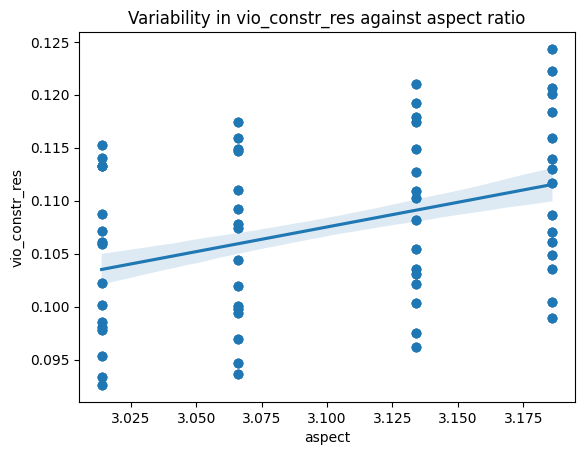

In [7]:
# Plot 2 vars from sample against each other
# Input epistemic uncertainty aspect against vio_constr_res
ax = sns.regplot(x=samples["aspect"], y=samples["vio_constr_res"])
ax.set_xlabel("aspect")
ax.set_ylabel("vio_constr_res")
ax.set_title("Variability in vio_constr_res against aspect ratio")

## Analysis

Analyse vio_constr_residuals, the violated constraint residuals.

### KDE for `vio_constr_res` from EasyVVUQ (plotted with seaborn)

Text(0, 0.5, 'Probability density')

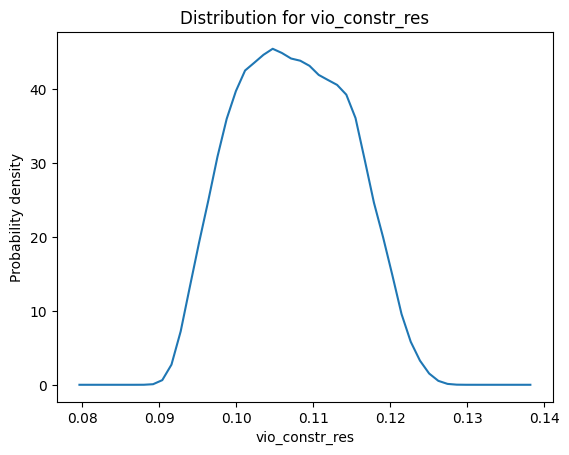

In [8]:
# Try to analyse all outputs variables: produces a linalg error
# results = campaign.analyse(qoi_cols=palph2_inputs)

# Analyse a single output variable, vio_constr_res
results = campaign.analyse(qoi_cols=["vio_constr_res"])

# Get its distribution
dist = results.get_distribution(qoi="vio_constr_res")

# Locations for density function to be evaluated
# (This is taken from easyvvuq's fusion tutorial)
x = np.linspace(dist.lower[0], dist.upper[0])
pdf = dist.pdf(x)

# Plot
ax = sns.lineplot(x=x, y=pdf, markers=True)
ax.set_title("Distribution for vio_constr_res")
ax.set_xlabel("vio_constr_res")
ax.set_ylabel("Probability density")
# Again, this is different on each run: something stochastic

PDF for `vio_constr_res`. Appears right from looking at the EasyVVUQ tutorial (fusion Dask).

## Sobol indices

Can we get Sobol information out of this?

In [1]:
# results.plot_moments(qoi="vio_constr_res")
# results.plot_sobols_first("vio_constr_res") # only for vecotr qois. Like constraint vectors?

# Div by zero bug goes away when using more uncertainties
fig, ax = plt.subplots()
results.plot_sobols_treemap("vio_constr_res", figsize=(10, 10), ax=ax)
# ax.set_title("blah")

NameError: name 'plt' is not defined